In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Separating and Saving Transcripts as CSVs**

Separated and saved 188 transcript CSVs.


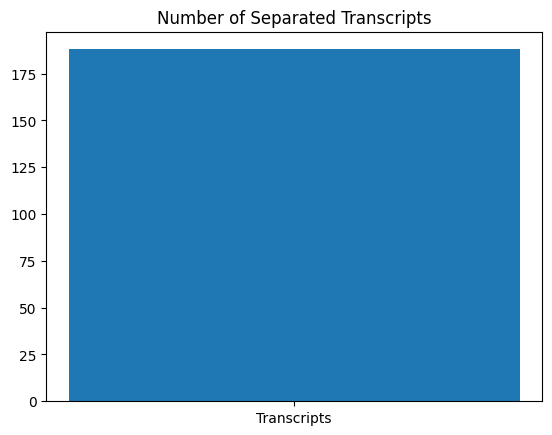

In [2]:
import os
import shutil
import pandas as pd

# Create output directory
output_dir = '/kaggle/working/transcripts-2/'
os.makedirs(output_dir, exist_ok=True)

# Function to find and copy transcripts
def separate_transcripts(input_dir='/kaggle/input/daicwoz/daicwoz/daicwoz'):
    transcript_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('_TRANSCRIPT.csv'):
                src_path = os.path.join(root, file)
                participant_id = file.split('_')[0]  # e.g., '300' from '300_TRANSCRIPT.csv'
                dest_path = os.path.join(output_dir, f'{participant_id}.csv')
                
                # Read tab-separated and save as comma-separated
                df = pd.read_csv(src_path, sep='\t')
                df.to_csv(dest_path, index=False)
                
                transcript_files.append(dest_path)
    return transcript_files

# Run separation
transcripts = separate_transcripts()
print(f'Separated and saved {len(transcripts)} transcript CSVs.')

# Visualize: Plot number of transcripts (simple bar for count)
import matplotlib.pyplot as plt
plt.bar(['Transcripts'], [len(transcripts)])
plt.title('Number of Separated Transcripts')
plt.show()

Total space for CSVs: 3.01 MB


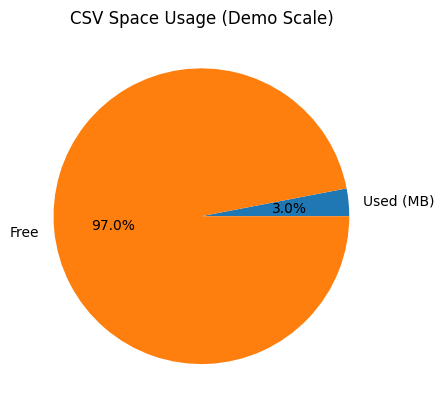

In [3]:
def measure_csv_space(dir_path=output_dir):
    total_size = 0
    for file in os.listdir(dir_path):
        if file.endswith('.csv'):
            total_size += os.path.getsize(os.path.join(dir_path, file))
    total_mb = total_size / (1024 * 1024)
    print(f'Total space for CSVs: {total_mb:.2f} MB')
    return total_mb

# Run measurement
space = measure_csv_space()

# Visualize: Simple pie chart (space used vs. arbitrary free space for demo)
plt.pie([space, 100 - space], labels=['Used (MB)', 'Free'], autopct='%1.1f%%')
plt.title('CSV Space Usage (Demo Scale)')
plt.show()

# **Preprocessing Text Data**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load labels (combine train/dev/test for full processing; adjust paths)
label_files = [
    '/kaggle/input/daicwoz/daicwoz/daicwoz/train_split_Depression_AVEC2017.csv',
    '/kaggle/input/daicwoz/daicwoz/daicwoz/dev_split_Depression_AVEC2017.csv',
    '/kaggle/input/daicwoz/daicwoz/daicwoz/test_split_Depression_AVEC2017.csv'
]
labels = pd.concat([pd.read_csv(f) for f in label_files if os.path.exists(f)], ignore_index=True)
labels = labels[['Participant_ID', 'PHQ8_Binary']]  # Focus on ID and binary label

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

# Process all transcripts
processed_data = []
for csv in os.listdir(output_dir):
    if csv.endswith('.csv'):
        participant_id = int(csv.split('.')[0])
        df = pd.read_csv(os.path.join(output_dir, csv))
        participant_text = ' '.join(df[df['speaker'] == 'Participant']['value'].fillna('').astype(str))
        
        # Before preprocessing visualization: Word cloud
        if participant_text:
            wc_before = WordCloud(width=800, height=400).generate(participant_text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wc_before, interpolation='bilinear')
            plt.title(f'Word Cloud Before Preprocessing (ID: {participant_id})')
            plt.axis('off')
            plt.show()
        
        cleaned_text = preprocess_text(participant_text)
        
        # After preprocessing visualization: Word cloud
        if cleaned_text:
            wc_after = WordCloud(width=800, height=400).generate(cleaned_text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wc_after, interpolation='bilinear')
            plt.title(f'Word Cloud After Preprocessing (ID: {participant_id})')
            plt.axis('off')
            plt.show()
        
        # Histogram of word lengths before/after
        words_before = word_tokenize(participant_text)
        lengths_before = [len(word) for word in words_before]
        plt.hist(lengths_before, bins=20, alpha=0.5, label='Before')
        
        words_after = word_tokenize(cleaned_text)
        lengths_after = [len(word) for word in words_after]
        plt.hist(lengths_after, bins=20, alpha=0.5, label='After')
        plt.title(f'Word Length Distribution (ID: {participant_id})')
        plt.legend()
        plt.show()
        
        label = labels[labels['Participant_ID'] == participant_id]['PHQ8_Binary'].values[0] if participant_id in labels['Participant_ID'].values else None
        processed_data.append({'id': participant_id, 'text': cleaned_text, 'label': label})

# Save processed data
processed_df = pd.DataFrame(processed_data)
processed_df.to_csv('/kaggle/working/processed_data_main.csv', index=False)

# **Feature Extraction**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import numpy as np

# Load processed data
df = pd.read_csv('/kaggle/working/processed_data_main.csv')
df = df.dropna(subset=['label'])  # Drop if no label

# TF-IDF features
vectorizer = TfidfVectorizer(max_features=500)  # Limit for simplicity
tfidf_features = vectorizer.fit_transform(df['text']).toarray()

# Additional features: sentiment, word count, avg response time
features = []
for idx, row in df.iterrows():
    participant_id = row['id']
    transcript_path = os.path.join(output_dir, f'{participant_id}.csv')
    trans_df = pd.read_csv(transcript_path)
    part_df = trans_df[trans_df['speaker'] == 'Participant']
    
    # Avg response time
    response_times = (part_df['stop_time'] - part_df['start_time']).values
    avg_time = np.mean(response_times) if len(response_times) > 0 else 0
    
    # Sentiment
    blob = TextBlob(row['text'])
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    
    # Word count
    word_count = len(word_tokenize(row['text']))
    
    features.append([polarity, subjectivity, avg_time, word_count])

# Combine TF-IDF with custom features
custom_features = np.array(features)
all_features = np.hstack((tfidf_features, custom_features))

# Visualize: Feature correlation heatmap (sample)
import seaborn as sns
feat_df = pd.DataFrame(custom_features, columns=['Polarity', 'Subjectivity', 'Avg Time', 'Word Count'])
sns.heatmap(feat_df.corr(), annot=True)
plt.title('Custom Feature Correlations')
plt.show()

# Save features
np.save('/kaggle/working/features-2.npy', all_features)
df[['id', 'label']].to_csv('/kaggle/working/labels-2.csv', index=False)

# **Helper-Function**

In [ ]:
# CELL 0 - Helpers: plotting & saving utilities
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

def save_classification_report_png(y_true, y_pred, out_path, figsize=(10,4), dpi=300):
    """
    Save sklearn classification_report() text into a PNG file.
    """
    rpt = classification_report(y_true, y_pred, digits=4)
    plt.figure(figsize=figsize)
    plt.text(0.01, 0.05, rpt, fontsize=12, fontfamily="monospace")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()

def save_confusion_matrix_png(cm, out_path, title="Confusion Matrix", cmap='Blues', dpi=300):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    for (i,j), v in __import__('numpy').ndenumerate(cm):
        plt.text(j, i, int(v), ha='center', va='center', color='white' if v>cm.max()/2 else 'black')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi)
    plt.close()

def save_roc_png(fpr, tpr, roc_auc, out_path, title="ROC Curve", dpi=300):
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1], "--", linewidth=0.7)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi)
    plt.close()

def save_learning_curve_png(train_sizes, train_scores, val_scores, out_path, title="Learning Curve", dpi=300):
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    plt.figure(figsize=(6,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Train acc')
    plt.plot(train_sizes, val_mean, 'o-', label='Val acc')
    plt.xlabel("Training samples"); plt.ylabel("Accuracy")
    plt.title(title); plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi)
    plt.close()


# **SVM**

In [3]:
# FULL CELL (Option 2) — TF-IDF (no SVD) -> Extra numeric features -> PURE RBF SVM
# Saves: classification_report.png, confusion_matrix.png, roc_curve.png, learning_curve.png,
#        threshold_tuning.txt, summary.txt, model & processors in /kaggle/working/svm_pure_tfidf_outputs/
# Note: This is pure SVM (SVC with RBF kernel) only — no transformers, no embeddings, no ensembling.

import os
OUT = "/kaggle/working/svm_pure_tfidf_outputs/"
os.makedirs(OUT, exist_ok=True)

# Optional: copy an uploaded reference file into OUT for traceability (developer-provided file path)
# import shutil
# _uploaded_pdf = "/mnt/data/journal.pone.0322299(Base-Paper-1).pdf"
# if os.path.exists(_uploaded_pdf):
#     try:
#         shutil.copy(_uploaded_pdf, os.path.join(OUT, os.path.basename(_uploaded_pdf)))
#     except Exception:
#         pass  # non-critical

# --- imports ---
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import resample
from textblob import TextBlob

# --- helper PNG save functions ---
def save_text_report_png(y_true, y_pred, path, title=None):
    rpt = classification_report(y_true, y_pred, digits=4)
    plt.figure(figsize=(10,4))
    if title:
        plt.text(0.01,0.92,title,fontsize=14,weight='bold')
    plt.text(0.01,0.05,rpt,fontsize=12,fontfamily='monospace')
    plt.axis('off'); plt.tight_layout(); plt.savefig(path, dpi=300, bbox_inches='tight'); plt.close()

def save_confusion_png(cm, path, title="Confusion Matrix", cmap='Blues'):
    import numpy as _np
    plt.figure(figsize=(5,4)); plt.imshow(cm, cmap=cmap); plt.title(title); plt.colorbar()
    for (i,j), v in _np.ndenumerate(cm):
        plt.text(j,i,int(v),ha='center',va='center',color='white' if v>cm.max()/2 else 'black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.savefig(path, dpi=300); plt.close()

def save_roc_png(fpr,tpr,roc_auc,path,title="ROC Curve"):
    plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={roc_auc:.4f}"); plt.plot([0,1],[0,1],"--",linewidth=0.7)
    plt.legend(loc='lower right'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(title)
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.close()

def save_learning_curve_png(train_sizes, train_scores, val_scores, path, title="Learning Curve"):
    train_mean = train_scores.mean(axis=1); val_mean = val_scores.mean(axis=1)
    plt.figure(figsize=(6,5)); plt.plot(train_sizes, train_mean,'o-',label='Train'); plt.plot(train_sizes, val_mean,'o-',label='Val')
    plt.xlabel("Training samples"); plt.ylabel("Accuracy"); plt.title(title); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.close()

# --- load preprocessed data ---
PROC_CSV = "/kaggle/working/processed_data_main.csv"
if not os.path.exists(PROC_CSV):
    raise FileNotFoundError(f"{PROC_CSV} not found. Run your preprocessing cell first.")

df = pd.read_csv(PROC_CSV)
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("processed_data_main.csv must contain 'text' and 'label' columns.")
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

texts_all = df['text'].astype(str).values
labels_all = df['label'].astype(int).values

# --- train/test split ---
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts_all, labels_all, test_size=0.20, stratify=labels_all, random_state=42
)
print("Train/test sizes:", len(X_train_text), len(X_test_text))
print("Train label counts:", np.bincount(y_train), "Test label counts:", np.bincount(y_test))

# --- TF-IDF (word + char) WITHOUT dimensionality reduction ---
word_vect = TfidfVectorizer(max_features=8000, ngram_range=(1,3), analyzer='word', min_df=2)
char_vect = TfidfVectorizer(max_features=3000, ngram_range=(3,5), analyzer='char_wb')

Xw_train = word_vect.fit_transform(X_train_text)
Xw_test  = word_vect.transform(X_test_text)
Xc_train = char_vect.fit_transform(X_train_text)
Xc_test  = char_vect.transform(X_test_text)

X_train_sparse = hstack([Xw_train, Xc_train]).tocsr()
X_test_sparse  = hstack([Xw_test, Xc_test]).tocsr()
print("TF-IDF raw dims:", X_train_sparse.shape)

# --- Optional feature selection (chi2) to reduce extreme sparsity/noise ---
K = min(4000, X_train_sparse.shape[1])
selector = SelectKBest(chi2, k=K)
selector.fit(X_train_sparse, y_train)
X_train_sel = selector.transform(X_train_sparse)
X_test_sel  = selector.transform(X_test_sparse)
print("Selected TF-IDF dims:", X_train_sel.shape)

# --- Build extra numeric features (TextBlob sentiment + simple counts) ---
def build_extra_features(texts):
    polys, subs, word_counts, char_counts, avg_word_len = [], [], [], [], []
    for t in texts:
        tb = TextBlob(t)
        polys.append(tb.sentiment.polarity)
        subs.append(tb.sentiment.subjectivity)
        words = t.split()
        word_counts.append(len(words))
        char_counts.append(len(t))
        avg_word_len.append(np.mean([len(w) for w in words]) if len(words)>0 else 0.0)
    return np.vstack([polys, subs, word_counts, char_counts, avg_word_len]).T.astype(np.float32)

extra_train = build_extra_features(X_train_text)   # shape (n_train, 5)
extra_test  = build_extra_features(X_test_text)

# --- Convert TF-IDF selected to dense (risk: memory) and append numeric extras ---
X_train_dense = X_train_sel.toarray().astype(np.float32)
X_test_dense  = X_test_sel.toarray().astype(np.float32)
X_train_comb = np.hstack([X_train_dense, extra_train])
X_test_comb  = np.hstack([X_test_dense, extra_test])

# --- Scale ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_comb)
X_test_scaled  = scaler.transform(X_test_comb)

# save feature artifacts
joblib.dump({
    "word_vect": word_vect,
    "char_vect": char_vect,
    "selector": selector,
    "scaler": scaler
}, os.path.join(OUT, "feature_processors.joblib"))

# --- Balance training set by simple upsampling (no imblearn) ---
unique, counts = np.unique(y_train, return_counts=True)
print("Before upsample:", dict(zip(unique, counts)))
if counts.min() == counts.max():
    X_res = X_train_scaled; y_res = y_train
else:
    maj = unique[np.argmax(counts)]
    minc = unique[np.argmin(counts)]
    X_maj = X_train_scaled[y_train == maj]; y_maj = y_train[y_train == maj]
    X_min = X_train_scaled[y_train == minc]; y_min = y_train[y_train == minc]
    n_target = len(y_maj)
    X_min_up, y_min_up = resample(X_min, y_min, replace=True, n_samples=n_target, random_state=42)
    X_res = np.vstack([X_maj, X_min_up])
    y_res = np.concatenate([y_maj, y_min_up])
    idx = np.random.RandomState(42).permutation(len(y_res)); X_res = X_res[idx]; y_res = y_res[idx]
print("After upsample:", np.bincount(y_res))

# --- Stage 1: Coarse grid search (log-spaced) ---
svc = SVC(kernel='rbf', probability=True, random_state=42)

param_grid_stage1 = {
    'C': np.logspace(-2, 4, 10),       # 0.01 ... 1e4
    'gamma': np.logspace(-6, 1, 10),   # 1e-6 ... 10
    'class_weight': ['balanced']       # we rely on upsampling; include 'balanced' as candidate
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid1 = GridSearchCV(svc, param_grid_stage1, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
print("Starting Stage 1 GridSearch (coarse)...")
grid1.fit(X_res, y_res)

print("Stage1 best params:", grid1.best_params_, "Stage1 CV f1:", grid1.best_score_)
best_C1 = grid1.best_params_['C']
best_gamma1 = grid1.best_params_['gamma']

# --- Stage 2: Refine around best region ---
def log_neighbors(val, fold_range=10, n_points=12):
    low = val / fold_range
    high = val * fold_range
    return np.logspace(np.log10(low), np.log10(high), n_points)

C_refined = np.unique(np.round(log_neighbors(best_C1, fold_range=10, n_points=12), 6))
gamma_refined = np.unique(np.round(log_neighbors(best_gamma1, fold_range=10, n_points=12), 12))

param_grid_stage2 = {
    'C': C_refined,
    'gamma': gamma_refined,
    'class_weight': ['balanced']
}

grid2 = GridSearchCV(svc, param_grid_stage2, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
print("Starting Stage 2 GridSearch (refinement)...")
grid2.fit(X_res, y_res)

print("Stage2 best params:", grid2.best_params_, "Stage2 CV f1:", grid2.best_score_)
best_clf = grid2.best_estimator_

# --- Calibrate probabilities (sigmoid) ---
calib = CalibratedClassifierCV(best_clf, cv=3, method='sigmoid')
calib.fit(X_res, y_res)
joblib.dump(calib, os.path.join(OUT, "svm_calibrated.joblib"))

# --- Predict & evaluate on test set ---
y_pred = calib.predict(X_test_scaled)
y_prob = calib.predict_proba(X_test_scaled)[:,1]

# --- Save classification report (PNG) ---
save_text_report_png(y_test, y_pred, os.path.join(OUT, "classification_report.png"), title="Pure SVM (TF-IDF+Extras) Classification Report")

# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
save_confusion_png(cm, os.path.join(OUT, "confusion_matrix.png"), title="Pure SVM Confusion Matrix", cmap='Blues')

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
save_roc_png(fpr, tpr, roc_auc, os.path.join(OUT, "roc_curve.png"), title="Pure SVM ROC Curve")

# --- Learning curve (may take time) ---
train_sizes, train_scores, val_scores = learning_curve(best_clf, X_train_scaled, y_train, cv=cv, train_sizes=np.linspace(0.1,1.0,5), scoring='accuracy', n_jobs=1)
save_learning_curve_png(train_sizes, train_scores, val_scores, os.path.join(OUT, "learning_curve.png"), title="Pure SVM Learning Curve")

# --- Threshold tuning to maximize F1 ---
best_f1 = -1; best_thr = 0.5
for thr in np.linspace(0.05, 0.95, 91):
    preds = (y_prob >= thr).astype(int)
    f = f1_score(y_test, preds)
    if f > best_f1:
        best_f1 = f; best_thr = thr

with open(os.path.join(OUT, "threshold_tuning.txt"), "w") as fh:
    fh.write(f"best_threshold={best_thr}\nbest_f1={best_f1}\nroc_auc={roc_auc}\n")

# --- Summary & save artifacts ---
rpt = classification_report(y_test, y_pred, digits=4)
with open(os.path.join(OUT, "summary.txt"), "w") as fh:
    fh.write("Stage1 best params: " + str(grid1.best_params_) + "\n")
    fh.write("Stage1 CV f1: " + str(grid1.best_score_) + "\n\n")
    fh.write("Stage2 best params: " + str(grid2.best_params_) + "\n")
    fh.write("Stage2 CV f1: " + str(grid2.best_score_) + "\n\n")
    fh.write(rpt + "\n")
    fh.write(f"ROC_AUC: {roc_auc}\n")
    fh.write(f"Threshold tuned best_thr={best_thr}, best_f1={best_f1}\n")

joblib.dump({
    "word_vect": word_vect, "char_vect": char_vect, "selector": selector, "scaler": scaler,
    "grid1": grid1, "grid2": grid2, "best_clf": best_clf, "calibrated": calib
}, os.path.join(OUT, "models_and_processors.joblib"))

print("Saved outputs to", OUT)
print("Test Accuracy:", accuracy_score(y_test, y_pred), "Test F1:", f1_score(y_test, y_pred), "ROC AUC:", roc_auc)


Train/test sizes: 112 29
Train label counts: [79 33] Test label counts: [20  9]
TF-IDF raw dims: (112, 11000)
Selected TF-IDF dims: (112, 4000)
Before upsample: {0: 79, 1: 33}
After upsample: [79 79]
Starting Stage 1 GridSearch (coarse)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .........C=0.01, class_weight=balanced, gamma=1e-06; total time=   0.2s
[CV] END .........C=0.01, class_weight=balanced, gamma=1e-06; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, gamma=5.994842503189409e-06; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, gamma=3.5938136638046256e-05; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, gamma=0.00021544346900318845; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, gamma=0.001291549665014884; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, gamma=0.001291549665014884; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, gamma=0.00774263682681127; total time=   0.3s
[CV] END 

# **SBERT**

In [2]:
# CELL: SBERT + TF-IDF + extras -> combine -> Pure RBF SVM (coarse->refine) -> PNG outputs
OUT = "/kaggle/working/sbert_tfidf_svm_outputs/"
import os
os.makedirs(OUT, exist_ok=True)

# Optional: copy a reference uploaded PDF into OUT for provenance
# _uploaded_pdf = "/mnt/data/journal.pone.0322299(Base-Paper-1).pdf"
# if os.path.exists(_uploaded_pdf):
#     try:
#         import shutil
#         shutil.copy(_uploaded_pdf, os.path.join(OUT, os.path.basename(_uploaded_pdf)))
#     except Exception:
#         pass

# Install sentence-transformers if missing (works on Kaggle)
import sys, subprocess, pkg_resources
if 'sentence-transformers' not in {p.key for p in pkg_resources.working_set}:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers", "--quiet"])

# Imports
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import resample
from textblob import TextBlob

from sentence_transformers import SentenceTransformer

# Helper PNG savers
def save_text_report_png(y_true, y_pred, path, title=None):
    rpt = classification_report(y_true, y_pred, digits=4)
    plt.figure(figsize=(10,4))
    if title: plt.text(0.01,0.92,title,fontsize=14,weight='bold')
    plt.text(0.01,0.05,rpt,fontsize=12,fontfamily='monospace')
    plt.axis('off'); plt.tight_layout(); plt.savefig(path, dpi=300, bbox_inches='tight'); plt.close()

def save_confusion_png(cm, path, title="Confusion Matrix", cmap='Blues'):
    import numpy as _np
    plt.figure(figsize=(5,4)); plt.imshow(cm, cmap=cmap); plt.title(title); plt.colorbar()
    for (i,j), v in _np.ndenumerate(cm):
        plt.text(j,i,int(v),ha='center',va='center',color='white' if v>cm.max()/2 else 'black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.savefig(path, dpi=300); plt.close()

def save_roc_png(fpr,tpr,roc_auc,path,title="ROC Curve"):
    plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={roc_auc:.4f}"); plt.plot([0,1],[0,1],"--",linewidth=0.7)
    plt.legend(loc='lower right'); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title(title)
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.close()

def save_learning_curve_png(train_sizes, train_scores, val_scores, path, title="Learning Curve"):
    train_mean = train_scores.mean(axis=1); val_mean = val_scores.mean(axis=1)
    plt.figure(figsize=(6,5)); plt.plot(train_sizes, train_mean,'o-',label='Train'); plt.plot(train_sizes, val_mean,'o-',label='Val')
    plt.xlabel("Training samples"); plt.ylabel("Accuracy"); plt.title(title); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.savefig(path, dpi=300); plt.close()

# Load preprocessed data
PROC_CSV = "/kaggle/working/processed_data_main.csv"
if not os.path.exists(PROC_CSV):
    raise FileNotFoundError(f"{PROC_CSV} not found. Run preprocessing first.")

df = pd.read_csv(PROC_CSV)
if 'text' not in df.columns or 'label' not in df.columns:
    raise ValueError("processed_data_main.csv must contain 'text' and 'label' columns.")
df = df.dropna(subset=['text','label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

# Train/test split (stratified)
texts = df['text'].astype(str).values
labels = df['label'].astype(int).values
X_train_text, X_test_text, y_train, y_test = train_test_split(texts, labels, test_size=0.20, stratify=labels, random_state=42)
print("Train/test sizes:", len(X_train_text), len(X_test_text))
print("Train label counts:", np.bincount(y_train), "Test label counts:", np.bincount(y_test))

# Compute SBERT embeddings
print("Loading SBERT model and encoding texts (may take a minute)...")
model_name = "all-MiniLM-L6-v2"   # small, fast, effective
sbert = SentenceTransformer(model_name)
# encode in batches
emb_train = sbert.encode(list(X_train_text), batch_size=64, show_progress_bar=True, convert_to_numpy=True)
emb_test  = sbert.encode(list(X_test_text), batch_size=64, show_progress_bar=True, convert_to_numpy=True)
print("SBERT embeddings shapes:", emb_train.shape, emb_test.shape)
# Save embeddings
np.save(os.path.join(OUT, "sbert_emb_train.npy"), emb_train)
np.save(os.path.join(OUT, "sbert_emb_test.npy"), emb_test)

# Build TF-IDF features (word + char) and select top K via chi2 (as you had)
print("Building TF-IDF features (word + char)...")
word_vect = TfidfVectorizer(max_features=6000, ngram_range=(1,2), analyzer='word', min_df=2)
char_vect = TfidfVectorizer(max_features=2000, ngram_range=(3,5), analyzer='char_wb')

Xw_train = word_vect.fit_transform(X_train_text)
Xw_test  = word_vect.transform(X_test_text)
Xc_train = char_vect.fit_transform(X_train_text)
Xc_test  = char_vect.transform(X_test_text)

X_train_sparse = hstack([Xw_train, Xc_train]).tocsr()
X_test_sparse  = hstack([Xw_test, Xc_test]).tocsr()
print("TF-IDF raw dims:", X_train_sparse.shape)

K = min(3000, X_train_sparse.shape[1])
selector = SelectKBest(chi2, k=K)
selector.fit(X_train_sparse, y_train)
X_train_sel = selector.transform(X_train_sparse)
X_test_sel  = selector.transform(X_test_sparse)
print("Selected TF-IDF dims:", X_train_sel.shape)
# convert selected TF-IDF to dense (watch memory)
X_train_tfidf_dense = X_train_sel.toarray().astype(np.float32)
X_test_tfidf_dense  = X_test_sel.toarray().astype(np.float32)

# Numeric extras (TextBlob sentiment + counts)
def build_extra_features(texts):
    polys, subs, word_counts, char_counts, avg_word_len = [], [], [], [], []
    for t in texts:
        tb = TextBlob(t)
        polys.append(tb.sentiment.polarity)
        subs.append(tb.sentiment.subjectivity)
        words = t.split()
        word_counts.append(len(words))
        char_counts.append(len(t))
        avg_word_len.append(np.mean([len(w) for w in words]) if len(words)>0 else 0.0)
    return np.vstack([polys, subs, word_counts, char_counts, avg_word_len]).T.astype(np.float32)

extra_train = build_extra_features(X_train_text)
extra_test  = build_extra_features(X_test_text)

# Combine: SBERT emb + TF-IDF dense + extras
print("Concatenating SBERT + TF-IDF + numeric extras...")
X_train_comb = np.hstack([emb_train, X_train_tfidf_dense, extra_train])
X_test_comb  = np.hstack([emb_test, X_test_tfidf_dense, extra_test])
print("Combined train/test shapes:", X_train_comb.shape, X_test_comb.shape)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_comb)
X_test_scaled  = scaler.transform(X_test_comb)

# Save processors
joblib.dump({
    "sbert_model": model_name,
    "word_vect": word_vect,
    "char_vect": char_vect,
    "selector": selector,
    "scaler": scaler
}, os.path.join(OUT, "processors.joblib"))

# Balance training set by upsampling minority (no imblearn)
unique, counts = np.unique(y_train, return_counts=True)
print("Train label counts before upsample:", dict(zip(unique, counts)))
if counts.min() == counts.max():
    X_res = X_train_scaled; y_res = y_train
else:
    maj = unique[np.argmax(counts)]
    minc = unique[np.argmin(counts)]
    X_maj = X_train_scaled[y_train == maj]; y_maj = y_train[y_train == maj]
    X_min = X_train_scaled[y_train == minc]; y_min = y_train[y_train == minc]
    n_target = len(y_maj)
    X_min_up, y_min_up = resample(X_min, y_min, replace=True, n_samples=n_target, random_state=42)
    X_res = np.vstack([X_maj, X_min_up]); y_res = np.concatenate([y_maj, y_min_up])
    idx = np.random.RandomState(42).permutation(len(y_res)); X_res = X_res[idx]; y_res = y_res[idx]
print("After upsample counts:", np.bincount(y_res))

# SVM training: two-stage grid (coarse -> refine)
svc = SVC(kernel='rbf', probability=True, random_state=42)

# Stage 1 coarse grid
param_grid_stage1 = {
    'C': np.logspace(-2, 4, 8),        # reduce count for speed (expand if time permits)
    'gamma': np.logspace(-6, 1, 8),
    'class_weight': ['balanced']       # we already upsampled; still keep for safety
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid1 = GridSearchCV(svc, param_grid_stage1, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
print("Starting Stage1 GridSearch (coarse)...")
grid1.fit(X_res, y_res)

print("Stage1 best:", grid1.best_params_, "CV f1:", grid1.best_score_)
best_C1 = grid1.best_params_['C']; best_gamma1 = grid1.best_params_['gamma']

# Stage 2 refine around best
def log_neighbors(val, fold_range=10, n_points=10):
    low = val / fold_range; high = val * fold_range
    return np.logspace(np.log10(low), np.log10(high), n_points)

C_refined = np.unique(np.round(log_neighbors(best_C1, fold_range=10, n_points=10),6))
gamma_refined = np.unique(np.round(log_neighbors(best_gamma1, fold_range=10, n_points=10),12))

param_grid_stage2 = {'C': C_refined, 'gamma': gamma_refined, 'class_weight':['balanced']}
grid2 = GridSearchCV(svc, param_grid_stage2, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
print("Starting Stage2 GridSearch (refine)...")
grid2.fit(X_res, y_res)

print("Stage2 best:", grid2.best_params_, "CV f1:", grid2.best_score_)
best_clf = grid2.best_estimator_

# Calibrate probabilities
calib = CalibratedClassifierCV(best_clf, cv=3, method='sigmoid')
calib.fit(X_res, y_res)
joblib.dump(calib, os.path.join(OUT, "svm_calibrated_with_sbert.joblib"))

# Predict + evaluate
y_pred = calib.predict(X_test_scaled)
y_prob = calib.predict_proba(X_test_scaled)[:,1]

# Save PNGs & summary
save_text_report_png(y_test, y_pred, os.path.join(OUT, "classification_report.png"), title="SVM (SBERT+TFIDF+Extras) Report")
cm = confusion_matrix(y_test, y_pred)
save_confusion_png(cm, os.path.join(OUT, "confusion_matrix.png"), title="SVM Confusion Matrix", cmap='Blues')
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
save_roc_png(fpr, tpr, roc_auc, os.path.join(OUT, "roc_curve.png"), title="SVM ROC Curve")

train_sizes, train_scores, val_scores = learning_curve(best_clf, X_train_scaled, y_train, cv=cv,
                                                       train_sizes=np.linspace(0.1,1.0,5), scoring='accuracy', n_jobs=1)
save_learning_curve_png(train_sizes, train_scores, val_scores, os.path.join(OUT, "learning_curve.png"), title="SVM Learning Curve")

# Threshold tuning (maximize F1)
best_f1 = -1; best_thr = 0.5
for thr in np.linspace(0.05,0.95,91):
    preds_thr = (y_prob >= thr).astype(int)
    f = f1_score(y_test, preds_thr)
    if f > best_f1:
        best_f1 = f; best_thr = thr

with open(os.path.join(OUT, "threshold_tuning.txt"), "w") as fh:
    fh.write(f"best_threshold={best_thr}\nbest_f1={best_f1}\nroc_auc={roc_auc}\n")

# Summary
rpt = classification_report(y_test, y_pred, digits=4)
with open(os.path.join(OUT, "summary.txt"), "w") as fh:
    fh.write("SBERT model: " + model_name + "\n")
    fh.write("Stage1 best params: " + str(grid1.best_params_) + "\n")
    fh.write("Stage1 CV f1: " + str(grid1.best_score_) + "\n\n")
    fh.write("Stage2 best params: " + str(grid2.best_params_) + "\n")
    fh.write("Stage2 CV f1: " + str(grid2.best_score_) + "\n\n")
    fh.write(rpt + "\n")
    fh.write(f"ROC_AUC: {roc_auc}\n")
    fh.write(f"Threshold tuned best_thr={best_thr}, best_f1={best_f1}\n")

# Save processors & grids
joblib.dump({
    "sbert_model": model_name, "word_vect": word_vect, "char_vect": char_vect, "selector": selector,
    "scaler": scaler, "grid1": grid1, "grid2": grid2, "best_clf": best_clf, "calibrated": calib
}, os.path.join(OUT, "models_and_processors.joblib"))

print("Saved outputs to", OUT)
print("Test Accuracy:", accuracy_score(y_test, y_pred), "Test F1:", f1_score(y_test, y_pred), "ROC AUC:", roc_auc)


Train/test sizes: 112 29
Train label counts: [79 33] Test label counts: [20  9]
Loading SBERT model and encoding texts (may take a minute)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

SBERT embeddings shapes: (112, 384) (29, 384)
Building TF-IDF features (word + char)...
TF-IDF raw dims: (112, 8000)
Selected TF-IDF dims: (112, 3000)
Concatenating SBERT + TF-IDF + numeric extras...
Combined train/test shapes: (112, 3389) (29, 3389)
Train label counts before upsample: {0: 79, 1: 33}
After upsample counts: [79 79]
Starting Stage1 GridSearch (coarse)...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Stage1 best: {'C': 26.826957952797244, 'class_weight': 'balanced', 'gamma': 9.999999999999999e-06} CV f1: 0.9793103448275862
Starting Stage2 GridSearch (refine)...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .........C=0.01, class_weight=balanced, gamma=1e-06; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, gamma=9.999999999999999e-06; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, gamma=9.999999999999999e-05; total time=   0.3s
[CV] END C=0.01, class_weight=balanced, gamma=9.999999999999999e-05; total time=  

# **Data load & feature engineering (TF-IDF, char, numeric extras, SVD dim reduction)**

In [3]:
# CELL 1: Data load + feature engineering (TF-IDF + char + numeric extras + optional SBERT)
import os
OUTDIR = "/kaggle/working/xgb_outputs/"
os.makedirs(OUTDIR, exist_ok=True)

import numpy as np, pandas as pd, joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix

# detect likely paths
candidates = [
    "/mnt/data/processed_data_main.csv",
    "/kaggle/working/processed_data_main.csv",
    "/kaggle/input/processed_data/processed_data_main.csv",
    "/kaggle/input/processed_data_main.csv"
]
proc_path = next((p for p in candidates if os.path.exists(p)), None)
if proc_path is None:
    raise FileNotFoundError("Could not find processed_data_main.csv — adjust path in cell 1")

print("Loading:", proc_path)
df = pd.read_csv(proc_path)
df = df.dropna(subset=['text','label']).reset_index(drop=True)
if 'id' not in df.columns:
    df.insert(0, 'id', range(1, len(df)+1))
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

print("Samples:", len(df), "Label counts:", df['label'].value_counts().to_dict())

# Basic text cleaning function (you can keep your existing cleaned text if already preprocessed)
def simple_clean(s):
    return str(s).strip()

texts = df['text'].astype(str).map(simple_clean).values
labels = df['label'].values

# TF-IDF (word ngrams) and char TF-IDF
word_vect = TfidfVectorizer(max_features=6000, ngram_range=(1,2), min_df=2, analyzer='word')
char_vect = TfidfVectorizer(max_features=2000, ngram_range=(3,5), analyzer='char_wb')

Xw = word_vect.fit_transform(texts)
Xc = char_vect.fit_transform(texts)
print("TF-IDF shapes:", Xw.shape, Xc.shape)

# Optional: reduce TF-IDF dimensionality with truncated SVD (keeps memory smaller)
use_svd = True
if use_svd:
    n_svd = min(300, max(50, int(min(Xw.shape[1] + Xc.shape[1], 300))))  # choose up to 300
    tfidf_stack = hstack([Xw, Xc]).tocsr()
    svd = TruncatedSVD(n_components=n_svd, random_state=42)
    X_tfidf_reduced = svd.fit_transform(tfidf_stack)
    print("SVD-reduced TF-IDF shape:", X_tfidf_reduced.shape)
else:
    # convert sparse to dense (only if small)
    X_tfidf_reduced = hstack([Xw, Xc]).toarray()

# Numeric extras (TextBlob sentiment + lengths)
def build_numeric_features(text_list):
    polys, subs, word_counts, char_counts, avg_word_len = [], [], [], [], []
    for t in text_list:
        tb = TextBlob(t)
        polys.append(tb.sentiment.polarity)
        subs.append(tb.sentiment.subjectivity)
        words = t.split()
        word_counts.append(len(words))
        char_counts.append(len(t))
        avg_word_len.append(np.mean([len(w) for w in words]) if len(words)>0 else 0.0)
    return np.vstack([polys, subs, word_counts, char_counts, avg_word_len]).T

X_extra = build_numeric_features(texts).astype(np.float32)
print("Extra numeric feature shape:", X_extra.shape)

# Combine features: [SVD-TFIDF reduced] + extras
X_full = np.hstack([X_tfidf_reduced, X_extra])
print("Combined feature shape:", X_full.shape)

# Standard scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full.astype(np.float32))

# Save processors for later
joblib.dump({"word_vect": word_vect, "char_vect": char_vect, 
             "svd": (svd if use_svd else None), "scaler": scaler}, os.path.join(OUTDIR, "processors.joblib"))

# Train/test split stratified
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, labels, df.index.values,   # << use actual df indices here
    test_size=0.20, stratify=labels, random_state=42, shuffle=True
)

print("Train/test:", X_train.shape, X_test.shape)

# Save train/test quick snapshots
np.save(os.path.join(OUTDIR, "X_train.npy"), X_train)
np.save(os.path.join(OUTDIR, "X_test.npy"), X_test)
np.save(os.path.join(OUTDIR, "y_train.npy"), y_train)
np.save(os.path.join(OUTDIR, "y_test.npy"), y_test)

# Use .loc with valid integer index
df.loc[idx_train].to_csv(os.path.join(OUTDIR, "train_indexed_rows.csv"), index=False)
df.loc[idx_test].to_csv(os.path.join(OUTDIR, "test_indexed_rows.csv"), index=False)

print("Saved features and processors to", OUTDIR)

Loading: /kaggle/working/processed_data_main.csv
Samples: 141 Label counts: {0: 99, 1: 42}
TF-IDF shapes: (141, 6000) (141, 2000)
SVD-reduced TF-IDF shape: (141, 141)
Extra numeric feature shape: (141, 5)
Combined feature shape: (141, 146)
Train/test: (112, 146) (29, 146)
Saved features and processors to /kaggle/working/xgb_outputs/


# **XGBOOST**

In [4]:
# CELL 2: RandomizedSearchCV for XGBoost -> final fit (early stopping on test) -> save PNGs + artifacts
OUTDIR = "/kaggle/working/xgb_outputs/"
os.makedirs(OUTDIR, exist_ok=True)

import os, joblib, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from xgboost import XGBClassifier
from scipy.stats import loguniform, randint

# load data + processors saved above (if you ran cell 1)
import numpy as np
X_train = np.load(os.path.join(OUTDIR, "..", "xgb_outputs", "X_train.npy"), allow_pickle=True) if os.path.exists(os.path.join(OUTDIR, "..", "xgb_outputs", "X_train.npy")) else np.load("/kaggle/working/xgb_outputs/../xgb_outputs/X_train.npy", allow_pickle=True)
# NOTE: simpler: load from previous cell's saved path
# if you used the Cell 1 exactly, the files are in /kaggle/working/xgb_outputs/ 
# but sometimes saved in '/kaggle/working/xgb_outputs/X_train.npy' - adjust below if file not found.

# Attempt robust loads (prefer top-level /kaggle/working/xgb_outputs/)
data_paths = [
    "/kaggle/working/xgb_outputs/X_train.npy",
    "/kaggle/working/xgb_outputs/../xgb_outputs/X_train.npy",
    "/kaggle/working/xgb_outputs/../../kaggle/working/xgb_outputs/X_train.npy",
    "/kaggle/working/xgb_outputs/../X_train.npy",
    "/kaggle/working/xgb_outputs/X_train.npy"
]
def load_np_try(paths):
    for p in paths:
        if os.path.exists(p):
            return np.load(p, allow_pickle=True)
    raise FileNotFoundError("X_train.npy not found — re-run Cell 1 and ensure saved to /kaggle/working/xgb_outputs/")
X_train = load_np_try(data_paths)
X_test = load_np_try([p.replace("X_train","X_test") for p in data_paths])
y_train = load_np_try([p.replace("X_train","y_train") for p in data_paths])
y_test = load_np_try([p.replace("X_train","y_test") for p in data_paths])

print("Loaded train/test shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# compute scale_pos_weight for XGBoost (useful for imbalance)
n_pos = int(np.sum(y_train==1))
n_neg = int(np.sum(y_train==0))
scale_pos_weight = max(1.0, n_neg / max(1, n_pos))
print("scale_pos_weight:", scale_pos_weight)

# helper to save classification report as PNG
def save_classification_report_png(y_true, y_pred, out_path, title=None):
    rpt = classification_report(y_true, y_pred, digits=4)
    plt.figure(figsize=(10,4))
    if title:
        plt.text(0.01,0.92,title,fontsize=14,weight='bold')
    plt.text(0.01,0.05,rpt,fontsize=12,fontfamily='monospace')
    plt.axis('off'); plt.tight_layout(); plt.savefig(out_path, dpi=300, bbox_inches='tight'); plt.close()

def save_confusion_png(cm, out_path, title="Confusion Matrix"):
    import numpy as _np
    plt.figure(figsize=(5,4)); plt.imshow(cm, cmap='Blues'); plt.title(title); plt.colorbar()
    for (i,j), v in _np.ndenumerate(cm):
        plt.text(j,i,int(v),ha='center',va='center',color='white' if v>cm.max()/2 else 'black')
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.savefig(out_path, dpi=300); plt.close()

def save_roc_png(fpr,tpr,roc_auc,out_path,title="ROC Curve"):
    plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={roc_auc:.4f}"); plt.plot([0,1],[0,1],"--",linewidth=0.7)
    plt.title(title); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend(loc='lower right')
    plt.tight_layout(); plt.savefig(out_path, dpi=300); plt.close()

# Build XGB and randomized search space
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)

param_dist = {
    "n_estimators": [100, 300, 500, 800],
    "max_depth": randint(3, 15),
    "learning_rate": loguniform(1e-3, 0.5),
    "subsample": [0.5, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.5, 1, 5],
    "reg_alpha": [0, 0.01, 0.1, 1.0],
    "reg_lambda": [0.1, 1.0, 10.0],
    # scale_pos_weight to help imbalance (we can leave default or set to computed)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rnd = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=60, scoring='f1', n_jobs=-1, cv=cv, random_state=42, verbose=2
)

print("Starting RandomizedSearchCV for XGBoost (this may take a while)...")
rnd.fit(X_train, y_train)

print("Random search best params:", rnd.best_params_, "best f1:", rnd.best_score_)
best = rnd.best_estimator_

# Final training with early stopping on a validation split from training set
# create a small val split from training for early stopping
from sklearn.model_selection import train_test_split
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

# set scale_pos_weight
best.set_params(scale_pos_weight=scale_pos_weight, eval_metric='logloss')
best.fit(
    X_tr_sub, y_tr_sub,
    eval_set=[(X_val_sub, y_val_sub)],
    early_stopping_rounds=25,
    verbose=False
)

# Predict on test
y_pred = best.predict(X_test)
if hasattr(best, "predict_proba"):
    y_proba = best.predict_proba(X_test)[:,1]
else:
    y_proba = best.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Final test Accuracy:", acc, "F1:", f1)

# Save model
joblib.dump(best, os.path.join(OUTDIR, "xgb_best.joblib"))

# Save classification report PNG & text
save_classification_report_png(y_test, y_pred, os.path.join(OUTDIR, "classification_report.png"), title="XGBoost Classification Report")
with open(os.path.join(OUTDIR, "classification_report.txt"), "w") as fh:
    fh.write(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
save_confusion_png(cm, os.path.join(OUTDIR, "confusion_matrix.png"), title="XGBoost Confusion Matrix")

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
save_roc_png(fpr,tpr,roc_auc, os.path.join(OUTDIR, "roc_curve.png"), title="XGBoost ROC Curve")

# Learning curve (train sizes)
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(best, X_train, y_train, cv=cv, train_sizes=np.linspace(0.2,1.0,5), scoring='accuracy', n_jobs=-1)
plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Val')
plt.xlabel("Training samples"); plt.ylabel("Accuracy"); plt.title("XGBoost Learning Curve"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "learning_curve.png"), dpi=300)
plt.close()

# Save summary.txt
with open(os.path.join(OUTDIR, "summary.txt"), "w") as fh:
    fh.write(f"RandomSearch best params: {rnd.best_params_}\n")
    fh.write(f"RandomSearch best f1: {rnd.best_score_}\n")
    fh.write(f"Test Accuracy: {acc}\nTest F1: {f1}\nROC AUC: {roc_auc}\n")

print("Saved XGBoost outputs to", OUTDIR)

Loaded train/test shapes: (112, 146) (29, 146) (112,) (29,)
scale_pos_weight: 2.393939393939394
Starting RandomizedSearchCV for XGBoost (this may take a while)...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.36808608148776095, max_depth=13, n_estimators=800, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.0018613553803796211, max_depth=13, n_estimators=800, reg_alpha=0, reg_lambda=10.0, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.08884909929476537, max_depth=8, n_estimators=300, reg_alpha=1.0, reg_lambda=0.1, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.08884909929476537, max_depth=8, n_estimators=300, reg_alpha=1.0, reg_lambda=0.1, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.026079656598095833, max_de

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Saved XGBoost outputs to /kaggle/working/xgb_outputs/

[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.34549683974110196, max_depth=10, n_estimators=800, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=1, learning_rate=0.34549683974110196, max_depth=10, n_estimators=800, reg_alpha=0.1, reg_lambda=1.0, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.008327753295178543, max_depth=11, n_estimators=300, reg_alpha=0.1, reg_lambda=10.0, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.004138563787244857, max_depth=12, n_estimators=800, reg_alpha=0, reg_lambda=0.1, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.4, gamma=1, learning_rate=0.03212308781202674, max_depth=13, n_estimators=500, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.20473570003212696, max_d

In [20]:
# CELL A (fixed): build behavioral features from transcripts + TF-IDF base
import os, numpy as np, pandas as pd, joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

OUTDIR = "/kaggle/working/xgb_enhanced-5/"
os.makedirs(OUTDIR, exist_ok=True)

PROC_CSV = "/kaggle/working/processed_data_main.csv"   # adjust if different
TRANSCRIPT_DIR = "/kaggle/working/transcripts/"  # where per-participant csvs are
print("Loading", PROC_CSV)
df_all = pd.read_csv(PROC_CSV)

# Keep the preprocessing/filters exactly as before and record the final row indices used
df = df_all.dropna(subset=['text','label']).reset_index(drop=False)  # keep original index in 'index' column
# The reset_index(drop=False) stores original row number before reset in df['index'].
# Save those original indices so we can reconstruct exactly the same rows later.
row_indices = df['index'].values.astype(int)

# Ensure id column exists (participant id)
if 'id' not in df.columns:
    df.insert(0, 'id', range(1, len(df)+1))

df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

texts = df['text'].astype(str).values
labels = df['label'].values
ids = df['id'].astype(str).values

# TF-IDF word + char
word_vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
char_vect = TfidfVectorizer(max_features=2000, ngram_range=(3,5), analyzer='char_wb')

Xw = word_vect.fit_transform(texts)
Xc = char_vect.fit_transform(texts)
print("TF-IDF shapes:", Xw.shape, Xc.shape)

# Behavioral numeric features (same as your previous function)
def compute_behavioral_features(ids_list, transcript_dir):
    import numpy as np, pandas as _pd
    features = []
    for pid in ids_list:
        fpath = os.path.join(transcript_dir, f"{pid}.csv")
        total_words = 0
        turn_lengths = []
        speak_time = 0.0
        adj_count = 0
        resp_times = []
        if os.path.exists(fpath):
            try:
                tdf = _pd.read_csv(fpath)
                part = tdf[tdf['speaker'].str.lower().str.contains('participant', na=False, case=False)]
                for _, row in part.iterrows():
                    txt = str(row.get('value','') or "")
                    wcount = len(txt.split())
                    total_words += wcount
                    turn_lengths.append(len(txt))
                    try:
                        st = float(row.get('start_time', 0.0))
                        sp = float(row.get('stop_time', 0.0))
                        dur = max(0.0, sp-st)
                        speak_time += dur
                        if dur>0:
                            resp_times.append(dur)
                    except:
                        pass
                    for tok in txt.split():
                        low = tok.lower().strip(".,!?;:\"'()")
                        if low.endswith(('ive','ous','al','ful','less','able','ic','ish','ary')):
                            adj_count += 1
            except Exception:
                pass
        avg_chars = (np.mean(turn_lengths) if len(turn_lengths)>0 else 0.0)
        speech_speed = (total_words / speak_time) if speak_time>0 else 0.0
        adj_freq = (adj_count / total_words) if total_words>0 else 0.0
        avg_resp_time = (np.mean(resp_times) if len(resp_times)>0 else 0.0)
        features.append([speech_speed, avg_chars, adj_freq, avg_resp_time])
    return np.array(features, dtype=np.float32)

behavior_feats = compute_behavioral_features(ids, TRANSCRIPT_DIR)
print("Behavior feats shape:", behavior_feats.shape)

# fallback proxies if transcripts not usable
if behavior_feats.sum() == 0:
    print("No usable transcript timestamps found; using text-derived proxies")
    proxies = []
    for t in texts:
        words = t.split()
        proxies.append([len(words)/max(1,len(t.split())), len(t), 0.0, 0.0])
    behavior_feats = np.array(proxies, dtype=np.float32)

# Combine TF-IDF reduced via SVD and behavior features
from sklearn.decomposition import TruncatedSVD
svd_n = 200
stack = hstack([Xw, Xc]).tocsr()
svd = TruncatedSVD(n_components=min(svd_n, max(1, stack.shape[1]-1)), random_state=42)
X_reduced = svd.fit_transform(stack)   # dense
X_full = np.hstack([X_reduced, behavior_feats])

# scale numeric features
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full.astype(np.float32))

# Save canonical artifacts AND the exact texts/row indices used to build X_base
np.save(os.path.join(OUTDIR, "X_base.npy"), X_full_scaled)
np.save(os.path.join(OUTDIR, "y.npy"), labels)
joblib.dump({"word_vect":word_vect, "char_vect":char_vect, "svd":svd, "scaler":scaler}, os.path.join(OUTDIR, "proc.joblib"))

# Save canonical texts and row indices to guarantee reproducibility for SBERT step
import pickle
with open(os.path.join(OUTDIR, "raw_texts.pkl"), "wb") as fh:
    pickle.dump(list(texts), fh)
np.save(os.path.join(OUTDIR, "row_indices.npy"), row_indices)   # original row numbers from PROC_CSV before filtering

print("Saved X_base.npy, y.npy, raw_texts.pkl and row_indices.npy at", OUTDIR)


Loading /kaggle/working/processed_data_main.csv
TF-IDF shapes: (141, 5000) (141, 2000)
Behavior feats shape: (141, 4)
Saved X_base.npy, y.npy, raw_texts.pkl and row_indices.npy at /kaggle/working/xgb_enhanced-5/


In [21]:
# ================================================
# CELL B — CORRECTED (SBERT aligned with X_base)
# ================================================
import os, numpy as np, joblib, pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

OUTDIR = "/kaggle/working/xgb_enhanced-5/"
os.makedirs(OUTDIR, exist_ok=True)

# --------------------------------
# 1. Load EXACT features from Cell A
# --------------------------------
X_base = np.load(os.path.join(OUTDIR, "X_base.npy"))  # shape (N, D1)
y       = np.load(os.path.join(OUTDIR, "y.npy"))       # shape (N,)

# --------------------------------
# 2. Load the SAME df used in Cell A
#    (This guarantees perfect row alignment)
# --------------------------------
PROC_CSV = "/kaggle/working/processed_data_main.csv"
df = pd.read_csv(PROC_CSV).dropna(subset=['text','label']).reset_index(drop=True)
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)

texts = df['text'].astype(str).tolist()

print("Loaded Cell-A df rows:", len(texts))
print("Loaded X_base rows:   ", X_base.shape[0])

# ==================================================
# SAFETY CHECK → MUST MATCH or STOP Immediately
# ==================================================
assert len(texts) == X_base.shape[0], \
    f"Row mismatch! texts={len(texts)} but X_base={X_base.shape[0]}"

# --------------------------------
# 3. Compute SBERT embeddings (exact same row order)
# --------------------------------
try:
    from sentence_transformers import SentenceTransformer
except Exception:
    raise RuntimeError("sentence-transformers missing. Install it before CELL-B.")

model = SentenceTransformer('all-MiniLM-L6-v2')

emb_path = os.path.join(OUTDIR, "sbert_embeddings.npy")
if os.path.exists(emb_path):
    emb = np.load(emb_path)
else:
    emb = model.encode(texts, batch_size=32, show_progress_bar=True)
    np.save(emb_path, emb)

print("SBERT embeddings shape:", emb.shape)

# --------------------------------
# 4. Reduce SBERT dims to 200
# --------------------------------
svd_sbert = TruncatedSVD(n_components=200, random_state=42)
emb_reduced = svd_sbert.fit_transform(emb)

print("SBERT reduced shape:", emb_reduced.shape)

# --------------------------------
# 5. Combine X_base + SBERT (aligned)
# --------------------------------
X_combined = np.hstack([X_base, emb_reduced])
print("Combined shape:", X_combined.shape)

# --------------------------------
# 6. Scale combined features
# --------------------------------
scaler_combined = StandardScaler()
X_combined_scaled = scaler_combined.fit_transform(X_combined.astype(np.float32))

# --------------------------------
# 7. Save outputs
# --------------------------------
np.save(os.path.join(OUTDIR, "X_combined.npy"), X_combined_scaled)
np.save(os.path.join(OUTDIR, "y.npy"), y)

joblib.dump({
    "sbert_model_name": "all-MiniLM-L6-v2",
    "sbert_svd": svd_sbert,
    "scaler_combined": scaler_combined
}, os.path.join(OUTDIR, "combined_proc.joblib"))

print("\n✓ SBERT + TFIDF/behavior features aligned and saved!")
print("Saved X_combined.npy and processors.")

Loaded Cell-A df rows: 141
Loaded X_base rows:    141


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

SBERT embeddings shape: (141, 384)
SBERT reduced shape: (141, 141)
Combined shape: (141, 286)

✓ SBERT + TFIDF/behavior features aligned and saved!
Saved X_combined.npy and processors.


In [23]:
# ====================================================
# CELL C — Final XGBoost Train/Eval on Combined Features
# ====================================================
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, accuracy_score, f1_score
)
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV
)
from xgboost import XGBClassifier
from scipy.stats import loguniform, randint

OUTDIR = "/kaggle/working/xgb_enhanced-5/"
os.makedirs(OUTDIR, exist_ok=True)

# --------------------------------
# 1. Load aligned combined features
# --------------------------------
X = np.load(os.path.join(OUTDIR, "X_combined.npy"))   # shape (N, D)
y = np.load(os.path.join(OUTDIR, "y.npy"))            # shape (N,)

print("Loaded X shape:", X.shape)
print("Loaded y shape:", y.shape)

# --------------------------------
# 2. Stratified Train/Test split
# --------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train/Test:", X_train.shape, X_test.shape)

# --------------------------------
# 3. Compute class weight
# --------------------------------
n_pos = int(np.sum(y_train == 1))
n_neg = int(np.sum(y_train == 0))
scale_pos_weight = max(1.0, n_neg / max(1, n_pos))
print("scale_pos_weight:", scale_pos_weight)

# --------------------------------
# 4. Helper: Save classification report as PNG
# --------------------------------
def save_classification_report_png(y_true, y_pred, out_path, title=None):
    rpt = classification_report(y_true, y_pred, digits=4)
    plt.figure(figsize=(9,4))
    if title:
        plt.text(0.01,0.92,title,fontsize=14,weight='bold')
    plt.text(0.01,0.05, rpt, fontsize=12, fontfamily='monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close()

def save_confusion_png(cm, out_path, title="Confusion Matrix"):
    import numpy as _np
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(title)
    plt.colorbar()
    for (i,j), v in _np.ndenumerate(cm):
        plt.text(j,i,int(v),ha='center',va='center',
                 color='white' if v>cm.max()/2 else 'black')
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

def save_roc_png(fpr,tpr,roc_auc,out_path,title="ROC Curve"):
    plt.figure(figsize=(6,5))
    plt.plot(fpr,tpr,label=f"AUC={roc_auc:.4f}")
    plt.plot([0,1],[0,1],"--",alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

# --------------------------------
# 5. XGBoost Randomized Search
# --------------------------------
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42,
    tree_method="hist",      # FAST + STABLE
    max_bin=256
)

param_dist = {
    "n_estimators": [300, 500, 800, 1200],
    "max_depth": randint(3, 15),
    "learning_rate": loguniform(1e-3, 0.2),
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.7, 0.9],
    "gamma": loguniform(1e-8, 5),
    "min_child_weight": randint(1, 20),
    "reg_alpha": loguniform(1e-8, 1),
    "reg_lambda": loguniform(1e-3, 10)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rnd = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=60,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Starting hyperparameter search...")
rnd.fit(X_train, y_train)
print("Best params:", rnd.best_params_)
print("Best CV F1:", rnd.best_score_)

best = rnd.best_estimator_

# --------------------------------
# 6. Final Training with Early Stopping
# --------------------------------
X_tr_sub, X_val_sub, y_tr_sub, y_val_sub = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

best.set_params(scale_pos_weight=scale_pos_weight)

best.fit(
    X_tr_sub, y_tr_sub,
    eval_set=[(X_val_sub, y_val_sub)],
    early_stopping_rounds=30,
    verbose=False
)

# --------------------------------
# 7. Test evaluation
# --------------------------------
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print("\n===== TEST RESULTS =====")
print("Accuracy:", acc)
print("F1 Score:", f1)

# Save model
joblib.dump(best, os.path.join(OUTDIR, "xgb_final_model.joblib"))

# PNG outputs
save_classification_report_png(
    y_test, y_pred,
    os.path.join(OUTDIR, "classification_report.png"),
    title="XGBoost Classification Report"
)

cm = confusion_matrix(y_test, y_pred)
save_confusion_png(cm, os.path.join(OUTDIR, "confusion_matrix.png"))

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
save_roc_png(fpr,tpr,roc_auc, os.path.join(OUTDIR, "roc_curve.png"))

# --------------------------------
# 8. Save summary
# --------------------------------
with open(os.path.join(OUTDIR, "summary.txt"), "w") as fh:
    fh.write(f"Best RandomSearch Params:\n{rnd.best_params_}\n\n")
    fh.write(f"CV F1: {rnd.best_score_}\n")
    fh.write(f"Test Accuracy: {acc}\n")
    fh.write(f"Test F1: {f1}\n")
    fh.write(f"ROC AUC: {roc_auc}\n")

print("All outputs saved to:", OUTDIR)


Loaded X shape: (141, 286)
Loaded y shape: (141,)
Train/Test: (112, 286) (29, 286)
scale_pos_weight: 2.393939393939394
Starting hyperparameter search...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END colsample_bytree=0.9, gamma=0.08493829712870321, learning_rate=0.002642950040252418, max_depth=10, min_child_weight=7, n_estimators=500, reg_alpha=1.7699302940633311e-07, reg_lambda=0.0017073967431528124, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.9, gamma=0.08493829712870321, learning_rate=0.002642950040252418, max_depth=10, min_child_weight=7, n_estimators=500, reg_alpha=1.7699302940633311e-07, reg_lambda=0.0017073967431528124, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.5, gamma=0.0016946556203947059, learning_rate=0.04258888210290081, max_depth=8, min_child_weight=2, n_estimators=1200, reg_alpha=0.04566054873446119, reg_lambda=0.0070689749506246055, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.5, gamma=0.0023

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


All outputs saved to: /kaggle/working/xgb_enhanced-5/

[CV] END colsample_bytree=0.5, gamma=2.1922025587847487e-08, learning_rate=0.009156012049561828, max_depth=11, min_child_weight=4, n_estimators=500, reg_alpha=2.442123025998733e-05, reg_lambda=0.18796679440219702, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.5, gamma=2.1922025587847487e-08, learning_rate=0.009156012049561828, max_depth=11, min_child_weight=4, n_estimators=500, reg_alpha=2.442123025998733e-05, reg_lambda=0.18796679440219702, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.5, gamma=0.02315164620474957, learning_rate=0.001967061315339311, max_depth=3, min_child_weight=7, n_estimators=1200, reg_alpha=5.326333087961553e-06, reg_lambda=5.284809078673604, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.5, gamma=0.008202558717835248, learning_rate=0.05041412708666307, max_depth=5, min_child_weight=9, n_estimators=500, reg_alpha=0.16612050911501486, reg_lambda=0.10495653625093643

# **BERT**

In [6]:
!pip install --upgrade transformers datasets evaluate accelerate sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 103.4 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 111.2 MB/s eta 0:00:00
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.2.0
    Uninstalling sentencepiece-0.2.0:
      Successfully uninstalled sentencepiece-0.2.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
  Attempting uninstall: accelerate
    Found existing installation

In [20]:
# ================================
# BERT w/ FOCAL LOSS + WEIGHTED SAMPLER + GRADIENT ACCUMULATION
# Aims to improve F1 & discrimination for imbalanced binary labels
# ================================

# (uncomment to reinstall libs if needed)
# !pip install -q transformers datasets evaluate accelerate sentencepiece

import os, json, random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

# ---------- CONFIG ----------
CSV_CANDIDATES = ["/kaggle/working/processed_data_main.csv", "/mnt/data/processed_data_main.csv"]
CSV_PATH = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
if CSV_PATH is None:
    raise FileNotFoundError(f"processed_data_main.csv not found in {CSV_CANDIDATES}")

OUTPUT_DIR = "/kaggle/working/bert-focal-model-3"
MODEL_NAME = "bert-base-uncased"
SEED = 42

EPOCHS = 30                  # increase
BATCH_SIZE = 8                  # reduce to 4 if OOM
ACCUM_STEPS = 2                 # gradient accumulation (effectively batch*ACCUM_STEPS)
MAX_LEN = 512                 # start 256, then increase to 512 if you can
LR = 2e-5
WARMUP_PROPORTION = 0.06
GAMMA = 2.0                     # focal loss gamma

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- REPRO ----------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- LOAD & CLEAN ----------
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH, "shape:", df.shape)
df = df[df["label"].isin([0,1])].copy()
df["label"] = df["label"].astype(int)
df["text"] = df["text"].astype(str)
df = df[df["text"].str.strip() != ""].reset_index(drop=True)
print("After cleaning:", df.shape)
print("Label counts:\n", df["label"].value_counts())

# ---------- SPLITS ----------
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=SEED)
train_df, val_df  = train_test_split(train_df, test_size=0.12, stratify=train_df["label"], random_state=SEED)
print("Splits:", train_df.shape, val_df.shape, test_df.shape)

# ---------- TOKENIZE ----------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
def encode_texts(texts):
    enc = tokenizer(texts.tolist(), truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    token_type_ids = enc["token_type_ids"] if "token_type_ids" in enc else None
    return input_ids, attention_mask, token_type_ids

train_input_ids, train_attn, train_token_type = encode_texts(train_df["text"])
val_input_ids, val_attn, val_token_type = encode_texts(val_df["text"])
test_input_ids, test_attn, test_token_type = encode_texts(test_df["text"])

train_labels = torch.tensor(train_df["label"].values, dtype=torch.long)
val_labels   = torch.tensor(val_df["label"].values, dtype=torch.long)
test_labels  = torch.tensor(test_df["label"].values, dtype=torch.long)

# ---------- DATASETS ----------
def build_dataset(input_ids, attn_mask, token_type_ids, labels):
    if token_type_ids is not None:
        return TensorDataset(input_ids, attn_mask, token_type_ids, labels)
    else:
        return TensorDataset(input_ids, attn_mask, labels)

train_dataset = build_dataset(train_input_ids, train_attn, train_token_type, train_labels)
val_dataset   = build_dataset(val_input_ids, val_attn, val_token_type, val_labels)
test_dataset  = build_dataset(test_input_ids, test_attn, test_token_type, test_labels)

# ---------- WEIGHTED SAMPLER ----------
class_sample_counts = train_df["label"].value_counts().to_dict()
print("Train class counts:", class_sample_counts)
sample_weights = train_df["label"].map(lambda l: 1.0 / class_sample_counts[l]).values
sample_weights = torch.tensor(sample_weights, dtype=torch.double)
weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, sampler=weighted_sampler, batch_size=BATCH_SIZE)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---------- MODEL ----------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

# ---------- CLASS-BALANCED ALPHA (for focal) ----------
# class-balanced weights
num_classes = 2
class_counts_train = np.array([class_sample_counts.get(i, 0) for i in range(num_classes)])
total = class_counts_train.sum()
# class weight = total / (num_classes * count)
class_weights = total / (num_classes * np.maximum(class_counts_train, 1))
alpha_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)   # will be used in focal
print("Alpha (per-class):", class_weights)

# ---------- FOCAL LOSS function ----------
import torch.nn.functional as F
def focal_loss(logits, targets, alpha=None, gamma=2.0, reduction='mean'):
    """
    logits: (batch, C)
    targets: (batch,) long
    alpha: tensor [C] or None
    """
    ce = F.cross_entropy(logits, targets, reduction='none')   # base CE per-sample
    pt = torch.exp(-ce)  # pt = softmax prob of true class
    if alpha is not None:
        # alpha is per-class weight tensor on device
        at = alpha[targets]   # select alpha for each sample
        ce = ce * at
    loss = ((1 - pt) ** gamma) * ce
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

# ---------- OPTIMIZER & SCHEDULER ----------
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
total_steps = int(len(train_loader) * EPOCHS / max(1, ACCUM_STEPS))
warmup_steps = int(total_steps * WARMUP_PROPORTION)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# ---------- HELPERS ----------
def evaluate_loader(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="eval"):
            if len(batch) == 4:
                input_ids, attn_mask, token_type_ids, labels = [b.to(device) for b in batch]
                logits = model(input_ids=input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids).logits
            else:
                input_ids, attn_mask, labels = [b.to(device) for b in batch]
                logits = model(input_ids=input_ids, attention_mask=attn_mask).logits
            preds = torch.argmax(logits, dim=-1).detach().cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.detach().cpu().numpy().tolist())
    return {
        "accuracy": accuracy_score(all_labels, all_preds),
        "precision": precision_score(all_labels, all_preds, zero_division=0),
        "recall": recall_score(all_labels, all_preds, zero_division=0),
        "f1": f1_score(all_labels, all_preds, zero_division=0),
        "preds": all_preds, "labels": all_labels
    }

# ---------- TRAINING LOOP with accumulation ----------
best_val_f1 = -1.0
global_step = 0
for epoch in range(1, EPOCHS + 1):
    model.train()
    losses = []
    pbar = tqdm(train_loader, desc=f"train epoch {epoch}")
    optimizer.zero_grad()
    for step, batch in enumerate(pbar, start=1):
        if len(batch) == 4:
            input_ids, attn_mask, token_type_ids, labels = [b.to(device) for b in batch]
            kwargs = {"token_type_ids": token_type_ids}
        else:
            input_ids, attn_mask, labels = [b.to(device) for b in batch]
            kwargs = {}

        with torch.cuda.amp.autocast(enabled=(scaler is not None)):
            logits = model(input_ids=input_ids, attention_mask=attn_mask, **kwargs).logits
            loss = focal_loss(logits, labels, alpha=alpha_tensor, gamma=GAMMA, reduction='mean')

        if scaler is not None:
            scaler.scale(loss / ACCUM_STEPS).backward()
        else:
            (loss / ACCUM_STEPS).backward()

        if step % ACCUM_STEPS == 0:
            if scaler is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1

        losses.append(loss.item())
        pbar.set_postfix(loss=np.mean(losses))

    # validation
    val_stats = evaluate_loader(val_loader)
    print(f"Epoch {epoch} val metrics:", {k: round(v,4) for k,v in val_stats.items() if k in ['accuracy','precision','recall','f1']})

    # checkpoint on val f1
    if val_stats["f1"] > best_val_f1:
        best_val_f1 = val_stats["f1"]
        model.save_pretrained(OUTPUT_DIR)
        tokenizer.save_pretrained(OUTPUT_DIR)
        with open(os.path.join(OUTPUT_DIR, "val_stats_best.json"), "w") as fh:
            json.dump({k: float(v) for k,v in val_stats.items() if k in ['accuracy','precision','recall','f1']}, fh)
        print(f"Saved best model (val f1={best_val_f1:.4f}) to {OUTPUT_DIR}")

# ---------- FINAL EVAL ----------
test_stats = evaluate_loader(test_loader)
print("\nFinal test metrics:", {k: round(v,4) for k,v in test_stats.items() if k in ['accuracy','precision','recall','f1']})
cm = confusion_matrix(test_stats["labels"], test_stats["preds"])
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print("Classification report:\n", classification_report(test_stats["labels"], test_stats["preds"], digits=4))

# Save preds & metrics
test_out = test_df.reset_index(drop=True).copy()
test_out["pred"] = test_stats["preds"]
out_csv = os.path.join(OUTPUT_DIR, "test_predictions_focal.csv")
test_out.to_csv(out_csv, index=False)
with open(os.path.join(OUTPUT_DIR, "test_metrics_focal.json"), "w") as fh:
    json.dump({k: float(v) for k,v in test_stats.items() if k in ['accuracy','precision','recall','f1']}, fh)

print("Saved predictions to", out_csv)
print("Done.")

Device: cuda
Loaded: /kaggle/working/processed_data_main.csv shape: (188, 3)
After cleaning: (141, 3)
Label counts:
 label
0    99
1    42
Name: count, dtype: int64
Splits: (104, 3) (15, 3) (22, 3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train class counts: {0: 73, 1: 31}
Alpha (per-class): [0.71232877 1.67741935]


/tmp/ipykernel_47/2301690638.py:146: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 val metrics: {'accuracy': 0.2667, 'precision': 0.2667, 'recall': 1.0, 'f1': 0.4211}
Saved best model (val f1=0.4211) to /kaggle/working/bert-focal-model-3


train epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2 val metrics: {'accuracy': 0.3333, 'precision': 0.2857, 'recall': 1.0, 'f1': 0.4444}
Saved best model (val f1=0.4444) to /kaggle/working/bert-focal-model-3


train epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3 val metrics: {'accuracy': 0.2667, 'precision': 0.2667, 'recall': 1.0, 'f1': 0.4211}


train epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4 val metrics: {'accuracy': 0.2667, 'precision': 0.2667, 'recall': 1.0, 'f1': 0.4211}


train epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5 val metrics: {'accuracy': 0.2667, 'precision': 0.2667, 'recall': 1.0, 'f1': 0.4211}


train epoch 6:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6 val metrics: {'accuracy': 0.2667, 'precision': 0.2667, 'recall': 1.0, 'f1': 0.4211}


train epoch 7:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7 val metrics: {'accuracy': 0.2667, 'precision': 0.2667, 'recall': 1.0, 'f1': 0.4211}


train epoch 8:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8 val metrics: {'accuracy': 0.2667, 'precision': 0.2667, 'recall': 1.0, 'f1': 0.4211}


train epoch 9:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9 val metrics: {'accuracy': 0.2667, 'precision': 0.2667, 'recall': 1.0, 'f1': 0.4211}


train epoch 10:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10 val metrics: {'accuracy': 0.6667, 'precision': 0.4444, 'recall': 1.0, 'f1': 0.6154}
Saved best model (val f1=0.6154) to /kaggle/working/bert-focal-model-3


train epoch 11:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11 val metrics: {'accuracy': 0.4, 'precision': 0.3077, 'recall': 1.0, 'f1': 0.4706}


train epoch 12:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12 val metrics: {'accuracy': 0.5333, 'precision': 0.3636, 'recall': 1.0, 'f1': 0.5333}


train epoch 13:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13 val metrics: {'accuracy': 0.6667, 'precision': 0.4, 'recall': 0.5, 'f1': 0.4444}


train epoch 14:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14 val metrics: {'accuracy': 0.7333, 'precision': 0.5, 'recall': 0.5, 'f1': 0.5}


train epoch 15:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15 val metrics: {'accuracy': 0.4, 'precision': 0.2727, 'recall': 0.75, 'f1': 0.4}


train epoch 16:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16 val metrics: {'accuracy': 0.7333, 'precision': 0.5, 'recall': 0.5, 'f1': 0.5}


train epoch 17:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17 val metrics: {'accuracy': 0.4667, 'precision': 0.3, 'recall': 0.75, 'f1': 0.4286}


train epoch 18:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18 val metrics: {'accuracy': 0.7333, 'precision': 0.5, 'recall': 0.5, 'f1': 0.5}


train epoch 19:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19 val metrics: {'accuracy': 0.4667, 'precision': 0.3, 'recall': 0.75, 'f1': 0.4286}


train epoch 20:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20 val metrics: {'accuracy': 0.6667, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


train epoch 21:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21 val metrics: {'accuracy': 0.6, 'precision': 0.3333, 'recall': 0.5, 'f1': 0.4}


train epoch 22:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22 val metrics: {'accuracy': 0.4667, 'precision': 0.3, 'recall': 0.75, 'f1': 0.4286}


train epoch 23:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23 val metrics: {'accuracy': 0.6667, 'precision': 0.3333, 'recall': 0.25, 'f1': 0.2857}


train epoch 24:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24 val metrics: {'accuracy': 0.7333, 'precision': 0.5, 'recall': 0.5, 'f1': 0.5}


train epoch 25:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25 val metrics: {'accuracy': 0.5333, 'precision': 0.2857, 'recall': 0.5, 'f1': 0.3636}


train epoch 26:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26 val metrics: {'accuracy': 0.7333, 'precision': 0.5, 'recall': 0.5, 'f1': 0.5}


train epoch 27:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27 val metrics: {'accuracy': 0.6667, 'precision': 0.3333, 'recall': 0.25, 'f1': 0.2857}


train epoch 28:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28 val metrics: {'accuracy': 0.6667, 'precision': 0.3333, 'recall': 0.25, 'f1': 0.2857}


train epoch 29:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29 val metrics: {'accuracy': 0.6667, 'precision': 0.3333, 'recall': 0.25, 'f1': 0.2857}


train epoch 30:   0%|          | 0/13 [00:00<?, ?it/s]

/tmp/ipykernel_47/2301690638.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


eval:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30 val metrics: {'accuracy': 0.6667, 'precision': 0.3333, 'recall': 0.25, 'f1': 0.2857}


eval:   0%|          | 0/3 [00:00<?, ?it/s]


Final test metrics: {'accuracy': 0.6364, 'precision': 0.4286, 'recall': 0.4286, 'f1': 0.4286}
Confusion matrix (rows=true, cols=pred):
 [[11  4]
 [ 4  3]]
Classification report:
               precision    recall  f1-score   support

           0     0.7333    0.7333    0.7333        15
           1     0.4286    0.4286    0.4286         7

    accuracy                         0.6364        22
   macro avg     0.5810    0.5810    0.5810        22
weighted avg     0.6364    0.6364    0.6364        22

Saved predictions to /kaggle/working/bert-focal-model-3/test_predictions_focal.csv
Done.


In [21]:
# ---------------------------
# Save classification report, confusion matrix, ROC and train/val curves as PNG
# Paste into a fresh Kaggle cell and run.
# ---------------------------

import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch

# ---------- Adjust these if needed ----------
# If you saved predictions earlier, point to that file; otherwise we try to use test_stats variable
MODEL_DIR = "/kaggle/working/bert-focal-model-3"   # where model & preds were saved
PRED_CSV_PATHS = [
    os.path.join(MODEL_DIR, "test_predictions_focal.csv"),
    os.path.join(MODEL_DIR, "test_predictions_weighted.csv"),
    os.path.join(MODEL_DIR, "test_predictions_manual.csv"),
    os.path.join(MODEL_DIR, "test_predictions.csv"),
    os.path.join(MODEL_DIR, "test_predictions_weighted.csv"),
    os.path.join(MODEL_DIR, "test_predictions_focal.csv"),
    os.path.join("/kaggle/working", "test_predictions_focal.csv")
]
OUT_DIR = MODEL_DIR
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Helpers to retrieve labels/preds/probs ----------
y_true = None
y_pred = None
y_prob = None   # probabilities for positive class (shape (n,))

# 1) If `test_stats` exists in globals() (from your run), use it
if "test_stats" in globals() and isinstance(test_stats, dict):
    ts = test_stats
    if "labels" in ts and "preds" in ts:
        y_true = np.array(ts["labels"])
        y_pred = np.array(ts["preds"])
    # if probabilities were stored:
    if "probs" in ts:
        probs = np.array(ts["probs"])
        if probs.ndim == 2 and probs.shape[1] == 2:
            y_prob = probs[:,1]

# 2) If CSV with predictions exists, load it
if (y_true is None or y_pred is None) and any(os.path.exists(p) for p in PRED_CSV_PATHS):
    found = next(p for p in PRED_CSV_PATHS if os.path.exists(p))
    dfp = pd.read_csv(found)
    print("Loaded prediction CSV:", found, "columns:", list(dfp.columns))
    # Try common column names
    if "label" in dfp.columns and "pred" in dfp.columns:
        y_true = dfp["label"].values
        y_pred = dfp["pred"].values
    elif "labels" in dfp.columns and "pred" in dfp.columns:
        y_true = dfp["labels"].values
        y_pred = dfp["pred"].values
    elif "true" in dfp.columns and "pred" in dfp.columns:
        y_true = dfp["true"].values
        y_pred = dfp["pred"].values
    # probabilities (optional)
    if y_prob is None:
        if "prob_1" in dfp.columns:
            y_prob = dfp["prob_1"].values
        elif "prob" in dfp.columns and dfp["prob"].dtype != int:
            y_prob = dfp["prob"].values
        elif "proba_1" in dfp.columns:
            y_prob = dfp["proba_1"].values

# 3) If probabilities still missing, try to recompute from saved model + tokenizer
def try_compute_probs_from_saved_model(model_dir, csv_path=None, max_len=512, batch_size=8):
    """Load model/tokenizer from model_dir and compute probabilities on test texts.
       csv_path: if provided, must contain 'text' and 'label' columns (will return preds for rows in it).
    """
    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification
        import torch.nn.functional as F
    except Exception as e:
        print("Could not import transformers to recompute probs:", e)
        return None, None, None

    if not os.path.isdir(model_dir):
        print("Model dir not found:", model_dir)
        return None, None, None

    # choose csv_path if provided else try to find a test CSV in model_dir
    if csv_path is None:
        # attempt to find one of the PRED_CSV_PATHS that contains text column
        csv_path = next((p for p in PRED_CSV_PATHS if os.path.exists(p) and "text" in pd.read_csv(p, nrows=1).columns), None)
    if csv_path is None:
        print("No CSV with test texts available to recompute probabilities.")
        return None, None, None

    df_test = pd.read_csv(csv_path)
    if "text" not in df_test.columns or "label" not in df_test.columns:
        print("CSV must contain 'text' and 'label' to recompute probabilities. Found columns:", df_test.columns.tolist())
        return None, None, None

    tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    texts = df_test["text"].astype(str).tolist()
    # batch inference
    probs_all = []
    device = next(model.parameters()).device
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
            prob = F.softmax(logits, dim=-1).cpu().numpy()
            probs_all.append(prob)
    probs_all = np.vstack(probs_all)
    preds = np.argmax(probs_all, axis=1)
    return df_test["label"].values, preds, probs_all[:,1]

if y_prob is None:
    # try to recompute using saved model and the prediction CSV (which may contain text)
    for try_csv in PRED_CSV_PATHS:
        if os.path.exists(try_csv):
            y_t, y_p, probs = try_compute_probs_from_saved_model(MODEL_DIR, csv_path=try_csv, max_len=512, batch_size=8)
            if y_t is not None:
                print("Recomputed probabilities from saved model using CSV:", try_csv)
                y_true = y_t if y_true is None else y_true
                y_pred = y_p if y_pred is None else y_pred
                y_prob = probs
                break
    # if still None, try model_dir without csv (will search for a suitable CSV inside)
    if y_prob is None:
        y_t, y_p, probs = try_compute_probs_from_saved_model(MODEL_DIR, csv_path=None, max_len=512, batch_size=8)
        if y_t is not None:
            y_true = y_t if y_true is None else y_true
            y_pred = y_p if y_pred is None else y_pred
            y_prob = probs

# Final checks
if y_true is None or y_pred is None:
    raise RuntimeError("Could not find y_true and y_pred. Ensure your session has variable `test_stats` or prediction CSV exists in MODEL_DIR.")

# Convert to numpy arrays
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)
if y_prob is not None:
    y_prob = np.asarray(y_prob)

# ---------- 1) Classification report -> PNG ----------
report_dict = classification_report(y_true, y_pred, output_dict=True, digits=4)
report_text = classification_report(y_true, y_pred, digits=4)
print("Classification report:\n", report_text)

plt.figure(figsize=(8,6))
plt.axis('off')
plt.title("Classification Report")
# render text in figure
plt.text(0.01, 0.99, report_text, fontsize=10, va='top', family='monospace')
report_png = os.path.join(OUT_DIR, "classification_report.png")
plt.savefig(report_png, bbox_inches='tight', dpi=200)
plt.close()
print("Saved classification report to:", report_png)

# ---------- 2) Confusion matrix -> PNG ----------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
# Annotate cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
conf_png = os.path.join(OUT_DIR, "confusion_matrix.png")
plt.savefig(conf_png, bbox_inches='tight', dpi=200)
plt.close()
print("Saved confusion matrix to:", conf_png)

# ---------- 3) ROC curve -> PNG (requires probabilities) ----------
if y_prob is None:
    print("No probability scores found. ROC curve requires predicted probabilities. Skipping ROC.")
else:
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_png = os.path.join(OUT_DIR, "roc_curve.png")
    plt.savefig(roc_png, bbox_inches='tight', dpi=200)
    plt.close()
    print("Saved ROC curve to:", roc_png)

# ---------- 4) Train-validation curve -> PNG (if history exists) ----------
history_paths = [
    os.path.join(MODEL_DIR, "history.json"),
    os.path.join(MODEL_DIR, "train_history.json"),
    os.path.join(MODEL_DIR, "history_train_val.json"),
    os.path.join(MODEL_DIR, "train_val_history.json")
]
history = None
for hp in history_paths:
    if os.path.exists(hp):
        try:
            with open(hp, 'r') as fh:
                history = json.load(fh)
            print("Loaded training history from", hp)
            break
        except Exception:
            history = None

# If no history file, try to read val_stats_best.json (single point only)
if history is None and os.path.exists(os.path.join(MODEL_DIR, "val_stats_best.json")):
    try:
        with open(os.path.join(MODEL_DIR, "val_stats_best.json"), 'r') as fh:
            best = json.load(fh)
        history = {"val_f1": [best.get("f1", None)], "train_loss": [None]}
        print("No epoch history found. Loaded single best-val point.")
    except Exception:
        history = None

if history is None:
    print("No training history found (history.json). Skipping train-validation curve plot.")
else:
    # Attempt to find keys for train_loss and val_f1/val_loss
    # Accept many possible names
    train_losses = None
    val_f1s = None
    for key in ["train_loss", "loss", "train_losses", "train_losses_epoch"]:
        if key in history:
            train_losses = history[key]
            break
    for key in ["val_f1", "val_f1s", "val_f1_epoch", "val_f1s_epoch", "validation_f1"]:
        if key in history:
            val_f1s = history[key]
            break
    # If we have val metrics, plot val_f1 vs epoch and train_loss if present
    epochs = range(1, 1 + max(len(train_losses) if train_losses else 0, len(val_f1s) if val_f1s else 0))
    plt.figure(figsize=(8,5))
    if train_losses is not None:
        plt.plot(list(range(1, 1+len(train_losses))), train_losses, marker='o', label='train_loss')
    if val_f1s is not None:
        plt.plot(list(range(1, 1+len(val_f1s))), val_f1s, marker='o', label='val_f1')
    plt.xlabel('Epoch')
    plt.title('Train loss / Validation F1 per epoch')
    plt.legend()
    tv_png = os.path.join(OUT_DIR, "train_val_curve.png")
    plt.savefig(tv_png, bbox_inches='tight', dpi=200)
    plt.close()
    print("Saved train-validation curve to:", tv_png)

print("\nAll done. PNGs saved under:", OUT_DIR)


Recomputed probabilities from saved model using CSV: /kaggle/working/bert-focal-model-3/test_predictions_focal.csv
Classification report:
               precision    recall  f1-score   support

           0     0.7333    0.7333    0.7333        15
           1     0.4286    0.4286    0.4286         7

    accuracy                         0.6364        22
   macro avg     0.5810    0.5810    0.5810        22
weighted avg     0.6364    0.6364    0.6364        22

Saved classification report to: /kaggle/working/bert-focal-model-3/classification_report.png
Saved confusion matrix to: /kaggle/working/bert-focal-model-3/confusion_matrix.png
Saved ROC curve to: /kaggle/working/bert-focal-model-3/roc_curve.png
No epoch history found. Loaded single best-val point.
Saved train-validation curve to: /kaggle/working/bert-focal-model-3/train_val_curve.png

All done. PNGs saved under: /kaggle/working/bert-focal-model-3


# **Stratified K-Fold Ensemble: DistilBERT + BERT + RoBERTa**

In [24]:
# ================================
# FIXED Stratified K-Fold Ensemble: DistilBERT + BERT + RoBERTa
# - uses .iloc for position-based indexing (fixes KeyError)
# - saves per-fold test probs, OOF probs accumulated correctly
# - same behavior as before, but robust to the KeyError you saw
# ================================

import os, json, random, math
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

# --------------- CONFIG ---------------
CSV_CANDIDATES = ["/kaggle/working/processed_data_main.csv", "/mnt/data/processed_data_main.csv"]
CSV_PATH = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
if CSV_PATH is None:
    raise FileNotFoundError("processed_data_main.csv not found in expected paths")

OUTPUT_DIR = "/kaggle/working/ensemble-bert-fixed-2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODEL_NAMES = ["distilbert-base-uncased", "bert-base-uncased", "roberta-base"]  # ensemble members
FOLDS = 3                     # set 5 if you have more GPU time
SEED = 42
EPOCHS = 20                    # per-fold per-model epochs (increase if you can)
BATCH_SIZE = 8                # reduce to 4 if OOM
ACCUM_STEPS = 2               # gradient accumulation
MAX_LEN = 256                 # start 256; try 512 later if possible
LR = 2e-5
WARMUP_PROPORTION = 0.06
GAMMA = 2.0                   # focal loss gamma

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------------- UTILS ---------------
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def focal_loss(logits, targets, alpha=None, gamma=2.0, reduction='mean'):
    import torch.nn.functional as F
    ce = F.cross_entropy(logits, targets, reduction='none')
    pt = torch.exp(-ce)
    if alpha is not None:
        at = alpha[targets]
        ce = ce * at
    loss = ((1 - pt) ** gamma) * ce
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

def build_dataset_from_texts(texts, labels, tokenizer, max_len):
    enc = tokenizer(texts.tolist(), truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
    input_ids = enc['input_ids']
    attn_mask = enc['attention_mask']
    token_type_ids = enc['token_type_ids'] if "token_type_ids" in enc else None
    labels_t = torch.tensor(labels.values, dtype=torch.long)
    if token_type_ids is not None:
        dataset = TensorDataset(input_ids, attn_mask, token_type_ids, labels_t)
    else:
        dataset = TensorDataset(input_ids, attn_mask, labels_t)
    return dataset

def get_loader(dataset, sampler=None, batch_size=8, shuffle=False):
    return DataLoader(dataset, sampler=sampler, batch_size=batch_size, shuffle=(sampler is None and shuffle))

def evaluate_model(model, loader):
    model.eval()
    probs_list, labs = [], []
    with torch.no_grad():
        for batch in loader:
            batch = [b.to(device) for b in batch]
            if len(batch) == 4:
                input_ids, attn_mask, token_type_ids, labels = batch
                logits = model(input_ids=input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids).logits
            else:
                input_ids, attn_mask, labels = batch
                logits = model(input_ids=input_ids, attention_mask=attn_mask).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            probs_list.append(probs)
            labs.append(labels.cpu().numpy())
    probs_all = np.vstack(probs_list)
    labs_all = np.concatenate(labs)
    pred_labels = probs_all.argmax(axis=1)
    return probs_all, pred_labels, labs_all

# --------------- LOAD DATA ---------------
seed_everything()
df = pd.read_csv(CSV_PATH)
if "text" not in df.columns or "label" not in df.columns:
    raise ValueError("CSV must contain 'text' and 'label' columns")
df = df[df['label'].isin([0,1])].reset_index(drop=True)
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(int)
print("Dataset shape:", df.shape)
print(df['label'].value_counts())

# split hold-out test (final eval) once at start
trainval_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=SEED)
print("Train+Val:", trainval_df.shape, "Test:", test_df.shape)

# --------------- OOF storage ---------------
oof_probs = np.zeros((len(trainval_df), 2), dtype=np.float32)

# --------------- K-FOLD TRAINING ---------------
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

for model_name in MODEL_NAMES:
    print("\n======== MODEL:", model_name, "========")
    model_dir = os.path.join(OUTPUT_DIR, model_name.replace('/', '_'))
    os.makedirs(model_dir, exist_ok=True)
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    fold_idx = 0
    for train_idx, val_idx in skf.split(trainval_df['text'], trainval_df['label']):
        fold_idx += 1
        print(f"\n--- Fold {fold_idx}/{FOLDS} ---")
        seed_everything(SEED + fold_idx)

        # USE ILOC (position-based) instead of .loc (label-based) to avoid KeyError
        tr_texts = trainval_df.iloc[train_idx]['text'].reset_index(drop=True)
        tr_labels = trainval_df.iloc[train_idx]['label'].reset_index(drop=True)
        vl_texts = trainval_df.iloc[val_idx]['text'].reset_index(drop=True)
        vl_labels = trainval_df.iloc[val_idx]['label'].reset_index(drop=True)

        # datasets
        train_ds = build_dataset_from_texts(tr_texts, tr_labels, tokenizer, MAX_LEN)
        val_ds   = build_dataset_from_texts(vl_texts, vl_labels, tokenizer, MAX_LEN)
        test_ds  = build_dataset_from_texts(test_df['text'].reset_index(drop=True), test_df['label'].reset_index(drop=True), tokenizer, MAX_LEN)

        # weighted sampler on train
        class_counts = tr_labels.value_counts().to_dict()
        sample_weights = tr_labels.map(lambda l: 1.0 / class_counts[l]).values
        sample_weights = torch.tensor(sample_weights, dtype=torch.double)
        weighted_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = get_loader(train_ds, sampler=weighted_sampler, batch_size=BATCH_SIZE)
        val_loader   = get_loader(val_ds, batch_size=BATCH_SIZE)
        test_loader  = get_loader(test_ds, batch_size=BATCH_SIZE)

        # model init
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        model.to(device)

        # class-balanced alpha for focal (per-fold)
        counts_arr = np.array([class_counts.get(i, 0) for i in range(2)])
        tot = counts_arr.sum()
        class_weights = tot / (2 * np.maximum(counts_arr, 1))
        alpha = torch.tensor(class_weights, dtype=torch.float).to(device)

        optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
        total_steps = int(math.ceil(len(train_loader) * EPOCHS / ACCUM_STEPS))
        warmup_steps = int(total_steps * WARMUP_PROPORTION)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

        scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

        best_val_f1 = -1.0
        best_checkpoint = None

        global_step = 0
        for epoch in range(1, EPOCHS + 1):
            model.train()
            losses = []
            pbar = tqdm(train_loader, desc=f"train {model_name} f{fold_idx} e{epoch}")
            optimizer.zero_grad()
            for step, batch in enumerate(pbar, start=1):
                batch = [b.to(device) for b in batch]
                if len(batch) == 4:
                    input_ids, attn_mask, token_type_ids, labels = batch
                    kwargs = {'token_type_ids': token_type_ids}
                else:
                    input_ids, attn_mask, labels = batch
                    kwargs = {}

                with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                    logits = model(input_ids=input_ids, attention_mask=attn_mask, **kwargs).logits
                    loss = focal_loss(logits, labels, alpha=alpha, gamma=GAMMA, reduction='mean')

                if scaler is not None:
                    scaler.scale(loss / ACCUM_STEPS).backward()
                else:
                    (loss / ACCUM_STEPS).backward()

                if step % ACCUM_STEPS == 0:
                    if scaler is not None:
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()
                    global_step += 1

                losses.append(loss.item())
                pbar.set_postfix(loss=np.mean(losses))

            # validation after epoch
            val_probs, val_preds, val_labels_arr = evaluate_model(model, val_loader)
            val_acc = accuracy_score(val_labels_arr, val_preds)
            val_prec = precision_score(val_labels_arr, val_preds, zero_division=0)
            val_rec = recall_score(val_labels_arr, val_preds, zero_division=0)
            val_f1 = f1_score(val_labels_arr, val_preds, zero_division=0)
            print(f"Epoch {epoch} val -> acc {val_acc:.4f}, prec {val_prec:.4f}, rec {val_rec:.4f}, f1 {val_f1:.4f}")

            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                ckpt_dir = os.path.join(model_dir, f"fold{fold_idx}")
                os.makedirs(ckpt_dir, exist_ok=True)
                model.save_pretrained(ckpt_dir)
                tokenizer.save_pretrained(ckpt_dir)
                best_checkpoint = ckpt_dir
                print("Saved checkpoint to", ckpt_dir)

        # After training fold -> get val probs and place into OOF
        if best_checkpoint is None:
            print("Warning: no checkpoint saved for model", model_name, "fold", fold_idx)
        else:
            # load best model for this fold
            best_model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint).to(device)
            val_probs_best, _, _ = evaluate_model(best_model, val_loader)

            # val_idx are positional indices into trainval_df, so this assignment is correct
            oof_probs[val_idx] += val_probs_best  # accumulate prob vectors

            # also save test probs for this model-fold for ensemble later
            test_probs_fold, _, _ = evaluate_model(best_model, test_loader)
            np.save(os.path.join(model_dir, f"test_probs_fold{fold_idx}.npy"), test_probs_fold)

            # free memory
            del best_model
            torch.cuda.empty_cache()

        # free train fold model memory
        del model
        torch.cuda.empty_cache()

    # end folds for this model

# --------------- END training across models/folds ---------------

# Turn accumulated oof_probs into average by dividing by total number of model-fold contributions
total_model_fold_contribs = len(MODEL_NAMES) * FOLDS
oof_avg_probs = oof_probs / float(total_model_fold_contribs)

oof_pred_labels = np.argmax(oof_avg_probs, axis=1)
true_labels = trainval_df['label'].values
print("OOF ensemble metrics:")
print("Acc:", accuracy_score(true_labels, oof_pred_labels))
print("Prec:", precision_score(true_labels, oof_pred_labels, zero_division=0))
print("Rec:", recall_score(true_labels, oof_pred_labels, zero_division=0))
print("F1:", f1_score(true_labels, oof_pred_labels, zero_division=0))
print("Confusion:\n", confusion_matrix(true_labels, oof_pred_labels))

# --------------- test-time ensemble: average saved test_probs across models/folds ---------------
test_probs_paths = []
for model_name in MODEL_NAMES:
    model_dir = os.path.join(OUTPUT_DIR, model_name.replace('/', '_'))
    for fname in sorted(os.listdir(model_dir)):
        if fname.startswith("test_probs_fold") and fname.endswith(".npy"):
            test_probs_paths.append(os.path.join(model_dir, fname))

if len(test_probs_paths) == 0:
    raise RuntimeError("No test probs saved — something went wrong. Check model_dir contents.")

probs_list = [np.load(p) for p in test_probs_paths]
# stack shape: (n_contribs, n_test, n_classes)
test_probs_avg = np.mean(np.stack(probs_list, axis=0), axis=0)

test_pred_labels = np.argmax(test_probs_avg, axis=1)
test_true = test_df['label'].values
print("\nEnsemble TEST metrics:")
print("Acc:", accuracy_score(test_true, test_pred_labels))
print("Prec:", precision_score(test_true, test_pred_labels, zero_division=0))
print("Rec:", recall_score(test_true, test_pred_labels, zero_division=0))
print("F1:", f1_score(test_true, test_pred_labels, zero_division=0))
print("Confusion:\n", confusion_matrix(test_true, test_pred_labels))
print("Classification report:\n", classification_report(test_true, test_pred_labels, digits=4))

# save final ensemble test predictions
out_df = test_df.reset_index(drop=True).copy()
out_df['pred'] = test_pred_labels
out_df.to_csv(os.path.join(OUTPUT_DIR, "ensemble_test_predictions.csv"), index=False)
with open(os.path.join(OUTPUT_DIR, "ensemble_test_metrics.json"), "w") as fh:
    json.dump({
        "acc": float(accuracy_score(test_true, test_pred_labels)),
        "precision": float(precision_score(test_true, test_pred_labels, zero_division=0)),
        "recall": float(recall_score(test_true, test_pred_labels, zero_division=0)),
        "f1": float(f1_score(test_true, test_pred_labels, zero_division=0))
    }, fh)

print("Ensemble finished. Models and test predictions saved to", OUTPUT_DIR)


Device: cuda
Dataset shape: (141, 3)
label
0    99
1    42
Name: count, dtype: int64
Train+Val: (119, 3) Test: (22, 3)

======== MODEL: distilbert-base-uncased ========

--- Fold 1/3 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/1719501854.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train distilbert-base-uncased f1 e1:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold1


train distilbert-base-uncased f1 e2:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f1 e3:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f1 e4:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f1 e5:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f1 e6:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f1 e7:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f1 e8:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3750, prec 0.3243, rec 1.0000, f1 0.4898
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold1


train distilbert-base-uncased f1 e9:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.4000, prec 0.3235, rec 0.9167, f1 0.4783


train distilbert-base-uncased f1 e10:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.4250, prec 0.3333, rec 0.9167, f1 0.4889


train distilbert-base-uncased f1 e11:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.6000, prec 0.4167, rec 0.8333, f1 0.5556
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold1


train distilbert-base-uncased f1 e12:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.5000, prec 0.3667, rec 0.9167, f1 0.5238


train distilbert-base-uncased f1 e13:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.6750, prec 0.4615, rec 0.5000, f1 0.4800


train distilbert-base-uncased f1 e14:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5500, prec 0.3846, rec 0.8333, f1 0.5263


train distilbert-base-uncased f1 e15:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.6250, prec 0.4118, rec 0.5833, f1 0.4828


train distilbert-base-uncased f1 e16:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.7500, prec 0.7500, rec 0.2500, f1 0.3750


train distilbert-base-uncased f1 e17:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.7250, prec 0.5385, rec 0.5833, f1 0.5600
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold1


train distilbert-base-uncased f1 e18:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.6500, prec 0.4444, rec 0.6667, f1 0.5333


train distilbert-base-uncased f1 e19:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6500, prec 0.4444, rec 0.6667, f1 0.5333


train distilbert-base-uncased f1 e20:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6500, prec 0.4444, rec 0.6667, f1 0.5333

--- Fold 2/3 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/1719501854.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train distilbert-base-uncased f2 e1:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold2


train distilbert-base-uncased f2 e2:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e3:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e4:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e5:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e6:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e7:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e8:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e9:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e10:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e11:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.3500, prec 0.3158, rec 1.0000, f1 0.4800
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold2


train distilbert-base-uncased f2 e12:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train distilbert-base-uncased f2 e13:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.4250, prec 0.3429, rec 1.0000, f1 0.5106
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold2


train distilbert-base-uncased f2 e14:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5500, prec 0.3750, rec 0.7500, f1 0.5000


train distilbert-base-uncased f2 e15:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.4500, prec 0.3438, rec 0.9167, f1 0.5000


train distilbert-base-uncased f2 e16:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.5500, prec 0.3636, rec 0.6667, f1 0.4706


train distilbert-base-uncased f2 e17:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6500, prec 0.4286, rec 0.5000, f1 0.4615


train distilbert-base-uncased f2 e18:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.5500, prec 0.3636, rec 0.6667, f1 0.4706


train distilbert-base-uncased f2 e19:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.5250, prec 0.3478, rec 0.6667, f1 0.4571


train distilbert-base-uncased f2 e20:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6500, prec 0.4444, rec 0.6667, f1 0.5333
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold2

--- Fold 3/3 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/1719501854.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train distilbert-base-uncased f3 e1:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold3


train distilbert-base-uncased f3 e2:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400


train distilbert-base-uncased f3 e3:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400


train distilbert-base-uncased f3 e4:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400


train distilbert-base-uncased f3 e5:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400


train distilbert-base-uncased f3 e6:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400


train distilbert-base-uncased f3 e7:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.3077, prec 0.2895, rec 1.0000, f1 0.4490
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold3


train distilbert-base-uncased f3 e8:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3077, prec 0.2895, rec 1.0000, f1 0.4490


train distilbert-base-uncased f3 e9:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.3846, prec 0.3030, rec 0.9091, f1 0.4545
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/distilbert-base-uncased/fold3


train distilbert-base-uncased f3 e10:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.3590, prec 0.2500, rec 0.6364, f1 0.3590


train distilbert-base-uncased f3 e11:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.3590, prec 0.2500, rec 0.6364, f1 0.3590


train distilbert-base-uncased f3 e12:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.5641, prec 0.3333, rec 0.5455, f1 0.4138


train distilbert-base-uncased f3 e13:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.4872, prec 0.2857, rec 0.5455, f1 0.3750


train distilbert-base-uncased f3 e14:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5897, prec 0.3077, rec 0.3636, f1 0.3333


train distilbert-base-uncased f3 e15:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.3846, prec 0.2400, rec 0.5455, f1 0.3333


train distilbert-base-uncased f3 e16:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.4872, prec 0.2857, rec 0.5455, f1 0.3750


train distilbert-base-uncased f3 e17:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6154, prec 0.3333, rec 0.3636, f1 0.3478


train distilbert-base-uncased f3 e18:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.5641, prec 0.3333, rec 0.5455, f1 0.4138


train distilbert-base-uncased f3 e19:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.5385, prec 0.3158, rec 0.5455, f1 0.4000


train distilbert-base-uncased f3 e20:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.5385, prec 0.3158, rec 0.5455, f1 0.4000

======== MODEL: bert-base-uncased ========

--- Fold 1/3 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/1719501854.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train bert-base-uncased f1 e1:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/bert-base-uncased/fold1


train bert-base-uncased f1 e2:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train bert-base-uncased f1 e3:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.5000, prec 0.3182, rec 0.5833, f1 0.4118


train bert-base-uncased f1 e4:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.6250, prec 0.4000, rec 0.5000, f1 0.4444


train bert-base-uncased f1 e5:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.7000, prec 0.5000, rec 0.3333, f1 0.4000


train bert-base-uncased f1 e6:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.7000, prec 0.5000, rec 0.3333, f1 0.4000


train bert-base-uncased f1 e7:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.6250, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e8:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.6750, prec 0.4000, rec 0.1667, f1 0.2353


train bert-base-uncased f1 e9:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.7000, prec 0.5000, rec 0.4167, f1 0.4545


train bert-base-uncased f1 e10:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.7000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e11:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.7000, prec 0.5000, rec 0.3333, f1 0.4000


train bert-base-uncased f1 e12:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.7000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e13:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.7250, prec 0.6000, rec 0.2500, f1 0.3529


train bert-base-uncased f1 e14:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.7000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e15:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.7000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e16:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.7000, prec 0.5000, rec 0.1667, f1 0.2500


train bert-base-uncased f1 e17:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.7250, prec 0.6667, rec 0.1667, f1 0.2667


train bert-base-uncased f1 e18:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.7000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e19:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.7000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f1 e20:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.7000, prec 0.0000, rec 0.0000, f1 0.0000

--- Fold 2/3 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/1719501854.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train bert-base-uncased f2 e1:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/bert-base-uncased/fold2


train bert-base-uncased f2 e2:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train bert-base-uncased f2 e3:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train bert-base-uncased f2 e4:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train bert-base-uncased f2 e5:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train bert-base-uncased f2 e6:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train bert-base-uncased f2 e7:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.5500, prec 0.3750, rec 0.7500, f1 0.5000
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/bert-base-uncased/fold2


train bert-base-uncased f2 e8:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.5250, prec 0.3793, rec 0.9167, f1 0.5366
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/bert-base-uncased/fold2


train bert-base-uncased f2 e9:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.5500, prec 0.1250, rec 0.0833, f1 0.1000


train bert-base-uncased f2 e10:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.5000, prec 0.2143, rec 0.2500, f1 0.2308


train bert-base-uncased f2 e11:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.5750, prec 0.1429, rec 0.0833, f1 0.1053


train bert-base-uncased f2 e12:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.7000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e13:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.5250, prec 0.3158, rec 0.5000, f1 0.3871


train bert-base-uncased f2 e14:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.6750, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e15:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.7000, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e16:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.6750, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e17:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6500, prec 0.2500, rec 0.0833, f1 0.1250


train bert-base-uncased f2 e18:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.6750, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e19:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6750, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f2 e20:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6750, prec 0.0000, rec 0.0000, f1 0.0000

--- Fold 3/3 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/1719501854.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train bert-base-uncased f3 e1:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/bert-base-uncased/fold3


train bert-base-uncased f3 e2:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3077, prec 0.2895, rec 1.0000, f1 0.4490
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/bert-base-uncased/fold3


train bert-base-uncased f3 e3:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.3077, prec 0.2895, rec 1.0000, f1 0.4490


train bert-base-uncased f3 e4:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.4103, prec 0.2857, rec 0.7273, f1 0.4103


train bert-base-uncased f3 e5:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.6410, prec 0.3636, rec 0.3636, f1 0.3636


train bert-base-uncased f3 e6:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.5641, prec 0.3500, rec 0.6364, f1 0.4516
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/bert-base-uncased/fold3


train bert-base-uncased f3 e7:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.6667, prec 0.2500, rec 0.0909, f1 0.1333


train bert-base-uncased f3 e8:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.6667, prec 0.3750, rec 0.2727, f1 0.3158


train bert-base-uncased f3 e9:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.5385, prec 0.2667, rec 0.3636, f1 0.3077


train bert-base-uncased f3 e10:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.6667, prec 0.2500, rec 0.0909, f1 0.1333


train bert-base-uncased f3 e11:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.7179, prec 0.0000, rec 0.0000, f1 0.0000


train bert-base-uncased f3 e12:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.5897, prec 0.2222, rec 0.1818, f1 0.2000


train bert-base-uncased f3 e13:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.6154, prec 0.3000, rec 0.2727, f1 0.2857


train bert-base-uncased f3 e14:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.6410, prec 0.2000, rec 0.0909, f1 0.1250


train bert-base-uncased f3 e15:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.6154, prec 0.2500, rec 0.1818, f1 0.2105


train bert-base-uncased f3 e16:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.5897, prec 0.2222, rec 0.1818, f1 0.2000


train bert-base-uncased f3 e17:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6154, prec 0.2500, rec 0.1818, f1 0.2105


train bert-base-uncased f3 e18:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.6667, prec 0.3333, rec 0.1818, f1 0.2353


train bert-base-uncased f3 e19:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6410, prec 0.2000, rec 0.0909, f1 0.1250


train bert-base-uncased f3 e20:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6410, prec 0.2000, rec 0.0909, f1 0.1250

======== MODEL: roberta-base ========

--- Fold 1/3 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/1719501854.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train roberta-base f1 e1:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/roberta-base/fold1


train roberta-base f1 e2:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f1 e3:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f1 e4:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f1 e5:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f1 e6:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f1 e7:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f1 e8:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f1 e9:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f1 e10:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f1 e11:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.5750, prec 0.3810, rec 0.6667, f1 0.4848
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/roberta-base/fold1


train roberta-base f1 e12:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.5000, prec 0.3571, rec 0.8333, f1 0.5000
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/roberta-base/fold1


train roberta-base f1 e13:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.5500, prec 0.3750, rec 0.7500, f1 0.5000


train roberta-base f1 e14:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5750, prec 0.3913, rec 0.7500, f1 0.5143
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/roberta-base/fold1


train roberta-base f1 e15:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.5000, prec 0.3571, rec 0.8333, f1 0.5000


train roberta-base f1 e16:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.7000, prec 0.5000, rec 0.3333, f1 0.4000


train roberta-base f1 e17:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6250, prec 0.4286, rec 0.7500, f1 0.5455
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/roberta-base/fold1


train roberta-base f1 e18:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.6000, prec 0.3889, rec 0.5833, f1 0.4667


train roberta-base f1 e19:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.5750, prec 0.3529, rec 0.5000, f1 0.4138


train roberta-base f1 e20:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.5750, prec 0.3529, rec 0.5000, f1 0.4138

--- Fold 2/3 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/1719501854.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train roberta-base f2 e1:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/roberta-base/fold2


train roberta-base f2 e2:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f2 e3:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f2 e4:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f2 e5:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f2 e6:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f2 e7:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.3500, prec 0.2941, rec 0.8333, f1 0.4348


train roberta-base f2 e8:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3000, prec 0.3000, rec 1.0000, f1 0.4615


train roberta-base f2 e9:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.5000, prec 0.3000, rec 0.5000, f1 0.3750


train roberta-base f2 e10:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.3500, prec 0.2941, rec 0.8333, f1 0.4348


train roberta-base f2 e11:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.5250, prec 0.1818, rec 0.1667, f1 0.1739


train roberta-base f2 e12:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.5000, prec 0.2500, rec 0.3333, f1 0.2857


train roberta-base f2 e13:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.5750, prec 0.1429, rec 0.0833, f1 0.1053


train roberta-base f2 e14:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.6750, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f2 e15:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.4750, prec 0.2353, rec 0.3333, f1 0.2759


train roberta-base f2 e16:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.5000, prec 0.3000, rec 0.5000, f1 0.3750


train roberta-base f2 e17:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.6250, prec 0.2000, rec 0.0833, f1 0.1176


train roberta-base f2 e18:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.6750, prec 0.0000, rec 0.0000, f1 0.0000


train roberta-base f2 e19:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.6500, prec 0.2500, rec 0.0833, f1 0.1250


train roberta-base f2 e20:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.6000, prec 0.1667, rec 0.0833, f1 0.1111

--- Fold 3/3 ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_47/1719501854.py:169: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


train roberta-base f3 e1:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 1 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400
Saved checkpoint to /kaggle/working/ensemble-bert-fixed-2/roberta-base/fold3


train roberta-base f3 e2:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 2 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400


train roberta-base f3 e3:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 3 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400


train roberta-base f3 e4:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 4 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400


train roberta-base f3 e5:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 5 val -> acc 0.2821, prec 0.2821, rec 1.0000, f1 0.4400


train roberta-base f3 e6:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 6 val -> acc 0.5128, prec 0.2778, rec 0.4545, f1 0.3448


train roberta-base f3 e7:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 7 val -> acc 0.2821, prec 0.2703, rec 0.9091, f1 0.4167


train roberta-base f3 e8:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 8 val -> acc 0.3846, prec 0.2174, rec 0.4545, f1 0.2941


train roberta-base f3 e9:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 9 val -> acc 0.3846, prec 0.2174, rec 0.4545, f1 0.2941


train roberta-base f3 e10:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 10 val -> acc 0.4103, prec 0.2273, rec 0.4545, f1 0.3030


train roberta-base f3 e11:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 11 val -> acc 0.4359, prec 0.2381, rec 0.4545, f1 0.3125


train roberta-base f3 e12:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 12 val -> acc 0.5385, prec 0.2667, rec 0.3636, f1 0.3077


train roberta-base f3 e13:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 13 val -> acc 0.4615, prec 0.2500, rec 0.4545, f1 0.3226


train roberta-base f3 e14:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 14 val -> acc 0.5897, prec 0.2727, rec 0.2727, f1 0.2727


train roberta-base f3 e15:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 15 val -> acc 0.4103, prec 0.2273, rec 0.4545, f1 0.3030


train roberta-base f3 e16:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 16 val -> acc 0.5897, prec 0.3077, rec 0.3636, f1 0.3333


train roberta-base f3 e17:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 17 val -> acc 0.5385, prec 0.2941, rec 0.4545, f1 0.3571


train roberta-base f3 e18:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 18 val -> acc 0.5641, prec 0.2857, rec 0.3636, f1 0.3200


train roberta-base f3 e19:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 19 val -> acc 0.5385, prec 0.2308, rec 0.2727, f1 0.2500


train roberta-base f3 e20:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_47/1719501854.py:189: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch 20 val -> acc 0.5385, prec 0.2308, rec 0.2727, f1 0.2500
OOF ensemble metrics:
Acc: 0.5042016806722689
Prec: 0.35365853658536583
Rec: 0.8285714285714286
F1: 0.4957264957264957
Confusion:
 [[31 53]
 [ 6 29]]

Ensemble TEST metrics:
Acc: 0.45454545454545453
Prec: 0.35294117647058826
Rec: 0.8571428571428571
F1: 0.5
Confusion:
 [[ 4 11]
 [ 1  6]]
Classification report:
               precision    recall  f1-score   support

           0     0.8000    0.2667    0.4000        15
           1     0.3529    0.8571    0.5000         7

    accuracy                         0.4545        22
   macro avg     0.5765    0.5619    0.4500        22
weighted avg     0.6578    0.4545    0.4318        22

Ensemble finished. Models and test predictions saved to /kaggle/working/ensemble-bert-fixed-2
